# **THESIS structure + ideas**
Detecting Vegetation Changes in Romania Using AI and GIS
- coordinator: Prof. Dr. Marc Frîncu
- student: Singh Nandhni Gabriela


# Final Written Thesis Outline (based on this research)

- title, keywords
- Abstract
- Introduction
  - Background & Motivation (why is it important?)
  - related work (literature review regarding: NDVI, remote sensing, U-Net, GIS tools -> what is missing?)
  - what is the value of this paper (what gap is filling or drawing awareness to?)
- Data & Methods
- Experiments & Results
  - the story with the tables, figuers, findings
- Discussion (implications, *awareness*, limitations)
- Conclusion & Future Work
  - summary the findings
  - list limitations
  - implications
- Refrences

In [ ]:
Tools & Technologies (All Python):
Google Colab

rasterio, numpy, pandas – for mask processing and vegetation % extraction

matplotlib, seaborn – visualization

scikit-learn – regression models

statsmodels – ARIMA time series

(Optional) fbprophet – advanced time series modeling

joblib – to save/load models if needed

# Google Earth Engine

JavaScript NDVI Script in the [Google Earth Engine Code Editor](https://code.earthengine.google.com/)

In [ ]:
// Romania boundary
var romania = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1")
                .filter(ee.Filter.eq('ADM0_NAME', 'Romania'));

// Visualization parameters
var ndviVis = {min: 0, max: 1, palette: ['white', 'green']};

// Loop over years 2019–2024
var years = [2019, 2020, 2021, 2022, 2023, 2024];

years.forEach(function(year) {
  var startDate = ee.Date.fromYMD(year, 4, 1);   // April 1st
  var endDate = ee.Date.fromYMD(year, 8, 30);    // July 30th

  var s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(romania)
    .filterDate(startDate, endDate)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    .median();

  var ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI');

  // Show NDVI layer (optional)
  Map.addLayer(ndvi.clip(romania), ndviVis, 'NDVI ' + year);

  // Export NDVI to Google Drive
  Export.image.toDrive({
    image: ndvi.clip(romania),
    description: 'NDVI_Romania_' + year,
    folder: 'GEE_NDVI_ROMANIA',
    scale: 10,
    region: romania.geometry(),
    fileFormat: 'GeoTIFF',
    maxPixels: 1e13
  });
});
Map.centerObject(romania, 6);


linking earth engine to google colab

In [ ]:
!pip install earthengine-api
!pip install geemap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.3 MB/s eta 0:00:00


In [ ]:
import ee
import geemap

# Try notebook authentication mode as an alternative
ee.Authenticate(auth_mode='notebook')

# Initialize Earth Engine
ee.Initialize()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/drive%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=qy17qxP9g8qAtL6nxlssHLuaee_AvyNx1wYdpAsNERs&tc=YItpCXWTSxOxA5ETCcwIPR2U50Q-KJ-l8c1wD9xI48U&cc=pNcZQCH_s6BBAa7zEmuu_wsm_ga13yuUTUiZ5FtvvPE

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AUJR-x4HEJ-12X5rACPlYqzdnWG8t__fmaCGrpqiiEYAd9AKLJRov7zFL3I

Successfully saved authorization token.


In [ ]:
import geemap.foliumap as geemap  # geemap folium mode for Colab

# Create a folium-based map centered on Romania
Map = geemap.Map(center=[45.9432, 24.9668], zoom=6)

# Add Romania boundary as a layer
Map.addLayer(romania.style(color='blue', fillColor='00000000'), {}, 'Romania Boundary')

# Display the map
Map


now, we save the files with ndvi

In [ ]:
import os

# Create a local folder to store NDVI files
output_folder = '/content/ndvi_romania_outputs'
os.makedirs(output_folder, exist_ok=True)

In [ ]:
# Load Romania counties
romania_counties = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1") \
                      .filter(ee.Filter.eq('ADM0_NAME', 'Romania'))

# Get the list of counties as client-side Python features
county_list = romania_counties.aggregate_array('ADM1_NAME').getInfo()

# Function to compute and export NDVI for a county and year
def export_ndvi_county(county_name, year):
    start_date = ee.Date.fromYMD(year, 4, 1)
    end_date = ee.Date.fromYMD(year, 8, 30)

    # Filter county feature
    county = romania_counties.filter(ee.Filter.eq('ADM1_NAME', county_name)).first()
    county_geom = ee.Feature(county).geometry()

    # Sentinel-2 image collection
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(county_geom) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
        .median()

    # Compute NDVI
    ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Clip to county
    ndvi_clipped = ndvi.clip(county_geom)

    # Safe file name
    safe_name = county_name.replace(" ", "_").replace("ș", "s").replace("ț", "t").replace("ă", "a").replace("î", "i").replace("â", "a")
    file_name = f'NDVI_{safe_name}_{year}.tif'
    file_path = os.path.join(output_folder, file_name)

    print(f'⬇️ Exporting {file_name} ...')

    try:
        geemap.ee_export_image(
            ndvi_clipped,
            filename=file_path,
            scale=50,
            region=county_geom,
            file_per_band=False
        )
        print(f'✅ Saved to {file_path}\n')
    except Exception as e:
        print(f'❌ Failed for {file_name}: {str(e)}\n')

# Loop over years and counties
years = [2019, 2020, 2021, 2022, 2023, 2024]

for year in years:
    for county in county_list:
        export_ndvi_county(county, year)


⬇️ Exporting NDVI_Alba_2019.tif ...
Generating URL ...
Please wait ...
Data downloaded to /content/ndvi_romania_outputs/NDVI_Alba_2019.tif
✅ Saved to /content/ndvi_romania_outputs/NDVI_Alba_2019.tif

⬇️ Exporting NDVI_Arad_2019.tif ...
Generating URL ...
Please wait ...
Data downloaded to /content/ndvi_romania_outputs/NDVI_Arad_2019.tif
✅ Saved to /content/ndvi_romania_outputs/NDVI_Arad_2019.tif

⬇️ Exporting NDVI_Arges_2019.tif ...
Generating URL ...
Please wait ...
Data downloaded to /content/ndvi_romania_outputs/NDVI_Arges_2019.tif
✅ Saved to /content/ndvi_romania_outputs/NDVI_Arges_2019.tif

⬇️ Exporting NDVI_Bacau_2019.tif ...
Generating URL ...
Please wait ...
Data downloaded to /content/ndvi_romania_outputs/NDVI_Bacau_2019.tif
✅ Saved to /content/ndvi_romania_outputs/NDVI_Bacau_2019.tif

⬇️ Exporting NDVI_Bihor_2019.tif ...
Generating URL ...
Please wait ...
Data downloaded to /content/ndvi_romania_outputs/NDVI_Bihor_2019.tif
✅ Saved to /content/ndvi_romania_outputs/NDVI_Bihor_2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/ndvi_romania_outputs /content/drive/MyDrive/Romania_by_County/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil

# Define source and destination paths
src_folder = '/content/ndvi_romania_outputs'
dst_folder = '/content/drive/MyDrive/Romania_by_County'

# Create the destination directory if it doesn't exist
os.makedirs(dst_folder, exist_ok=True)

# Copy the entire folder
shutil.copytree(src_folder, os.path.join(dst_folder, 'ndvi_romania_outputs'), dirs_exist_ok=True)

print("✅ NDVI files successfully copied to your Google Drive!")

✅ NDVI files successfully copied to your Google Drive!


In [ ]:
romania_counties = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1") \
                      .filter(ee.Filter.eq('ADM0_NAME', 'Romania'))

# List county names
county_names = romania_counties.aggregate_array('ADM1_NAME').getInfo()
print(sorted(county_names))


['Alba', 'Arad', 'Arges', 'Bacau', 'Bihor', 'Bistrita-nasaud', 'Botosani', 'Braila', 'Brasov', 'Bucuresti', 'Buzau', 'Calarasi', 'Caras-severin', 'Cluj', 'Constanta', 'Covasna', 'Dimbovita', 'Dolj', 'Galati', 'Giurgiu', 'Gorj', 'Harghita', 'Hunedoara', 'Ialomita', 'Iasi', 'Maramures', 'Mehedinti', 'Mures', 'Neamt', 'Olt', 'Prahova', 'Salaj', 'Satu Mare', 'Sibiu', 'Suceava', 'Teleorman', 'Timis', 'Tulcea', 'Vaslui', 'Vilcea', 'Vrancea']


In [ ]:
# Define the county you want to filter for (assuming you want to work with 'Timis' as seen in global variables)
# If you want a different county, change the string value below
county_to_filter = "Timis"

# Filter for the specific county using the defined variable
county_feature = romania_counties.filter(ee.Filter.eq('ADM1_NAME', county_to_filter)).first()

# Check if the county was found
if county_feature is None:
    print(f"❌ Could not find county: {county_to_filter}")
else:
    print(f"✅ Found county: {county_to_filter}")
    # You can now use county_feature for further operations like getting its geometry
    # county_geom = ee.Feature(county_feature).geometry()
    # print("County geometry obtained.")

✅ Found county: Timis


In [ ]:
missing_county = "Timis"  # or "Timiș" depending on actual spelling

for year in years:
    if missing_county in ["Timis", "Timiș"]:
        # Temporarily override export scale for large county
        original_export_ndvi_county = export_ndvi_county  # Backup original function

        def export_ndvi_county_scaled(county_name, year, custom_scale=100):
            start_date = ee.Date.fromYMD(year, 4, 1)
            end_date = ee.Date.fromYMD(year, 8, 30)

            county = romania_counties.filter(ee.Filter.eq('ADM1_NAME', county_name)).first()
            if county is None:
                print(f"❌ County not found: {county_name}")
                return

            county_geom = ee.Feature(county).geometry()

            s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                .filterBounds(county_geom) \
                .filterDate(start_date, end_date) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
                .median()

            ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')
            ndvi_clipped = ndvi.clip(county_geom)

            safe_name = county_name.replace(" ", "_").replace("ș", "s").replace("ț", "t") \
                                   .replace("ă", "a").replace("î", "i").replace("â", "a")
            file_name = f'NDVI_{safe_name}_{year}.tif'
            file_path = os.path.join(output_folder, file_name)

            print(f'⬇️ Exporting {file_name} with scale {custom_scale}m ...')

            try:
                geemap.ee_export_image(
                    ndvi_clipped,
                    filename=file_path,
                    scale=custom_scale,
                    region=county_geom,
                    file_per_band=False
                )
                print(f'✅ Saved to {file_path}\n')
            except Exception as e:
                print(f'❌ Failed for {file_name}: {str(e)}\n')

        export_ndvi_county_scaled(missing_county, year, custom_scale=100)
    else:
        export_ndvi_county(missing_county, year)


⬇️ Exporting NDVI_Timis_2019.tif with scale 100m ...
Generating URL ...
Please wait ...
Data downloaded to /content/ndvi_romania_outputs/NDVI_Timis_2019.tif
✅ Saved to /content/ndvi_romania_outputs/NDVI_Timis_2019.tif

⬇️ Exporting NDVI_Timis_2020.tif with scale 100m ...
Generating URL ...
Please wait ...
Data downloaded to /content/ndvi_romania_outputs/NDVI_Timis_2020.tif
✅ Saved to /content/ndvi_romania_outputs/NDVI_Timis_2020.tif

⬇️ Exporting NDVI_Timis_2021.tif with scale 100m ...
Generating URL ...
Please wait ...
Data downloaded to /content/ndvi_romania_outputs/NDVI_Timis_2021.tif
✅ Saved to /content/ndvi_romania_outputs/NDVI_Timis_2021.tif

⬇️ Exporting NDVI_Timis_2022.tif with scale 100m ...
Generating URL ...
Please wait ...
Data downloaded to /content/ndvi_romania_outputs/NDVI_Timis_2022.tif
✅ Saved to /content/ndvi_romania_outputs/NDVI_Timis_2022.tif

⬇️ Exporting NDVI_Timis_2023.tif with scale 100m ...
Generating URL ...
Please wait ...
Data downloaded to /content/ndvi_rom

In [ ]:
drive_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_romania_outputs'
os.makedirs(drive_folder, exist_ok=True)

for year in years:
    safe_name = missing_county.replace(" ", "_").replace("ș", "s").replace("ț", "t") \
                             .replace("ă", "a").replace("î", "i").replace("â", "a")
    file_name = f'NDVI_{safe_name}_{year}.tif'
    src_path = os.path.join(output_folder, file_name)
    dst_path = os.path.join(drive_folder, file_name)
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
        print(f'✅ Copied {file_name} to Google Drive.')
    else:
        print(f'⚠️ File {file_name} not found in local folder.')

✅ Copied NDVI_Timis_2019.tif to Google Drive.
✅ Copied NDVI_Timis_2020.tif to Google Drive.
✅ Copied NDVI_Timis_2021.tif to Google Drive.
✅ Copied NDVI_Timis_2022.tif to Google Drive.
✅ Copied NDVI_Timis_2023.tif to Google Drive.
✅ Copied NDVI_Timis_2024.tif to Google Drive.


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.0 MB/s eta 0:00:00


In [ ]:
!pip install ipywidgets folium rasterio
from google.colab import output
output.enable_custom_widget_manager()


In [ ]:
import folium
import rasterio
import numpy as np
from folium.raster_layers import ImageOverlay
from rasterio.enums import Resampling
import os
import ipywidgets as widgets
from IPython.display import display, clear_output

# 📁 Folder where NDVI files are saved
ndvi_folder = '/content/ndvi_romania_outputs'

# 🔍 List available .tif files
ndvi_files = sorted([f for f in os.listdir(ndvi_folder) if f.endswith('.tif')])

# 🗂️ Extract county and year info
county_year_dict = {}
for f in ndvi_files:
    parts = f.replace('.tif', '').split('_')
    county = '_'.join(parts[1:-1])
    year = parts[-1]
    county_year_dict.setdefault(county, []).append(year)

# Widgets
county_dropdown = widgets.Dropdown(options=sorted(county_year_dict.keys()), description='County:')
year_dropdown = widgets.Dropdown(description='Year:')

# Dynamically update years when county changes
def update_years(*args):
    year_dropdown.options = sorted(county_year_dict[county_dropdown.value])

county_dropdown.observe(update_years, 'value')
update_years()

# Display map function
def display_ndvi_map(county, year):
    file_name = f'NDVI_{county}_{year}.tif'
    file_path = os.path.join(ndvi_folder, file_name)

    try:
        with rasterio.open(file_path) as src:
            bounds = src.bounds
            ndvi = src.read(1, resampling=Resampling.bilinear)
            ndvi[ndvi == src.nodata] = np.nan

            # Normalize and convert to RGB
            norm = np.clip((ndvi - 0) / (1 - 0), 0, 1)
            rgba = plt.cm.YlGn(norm)
            rgb = (rgba[:, :, :3] * 255).astype(np.uint8)

        center = [(bounds.top + bounds.bottom)/2, (bounds.left + bounds.right)/2]
        m = folium.Map(location=center, zoom_start=8)

        overlay = ImageOverlay(
            image=rgb,
            bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
            opacity=0.7,
            name=f'NDVI {county} {year}'
        )
        overlay.add_to(m)
        folium.LayerControl().add_to(m)

        display(m)

    except Exception as e:
        print(f"❌ Error: {e}")

# Button to trigger map update
display_button = widgets.Button(description="🔍 Show Map")

def on_button_clicked(b):
    clear_output(wait=True)
    display(county_dropdown, year_dropdown, display_button)
    display_ndvi_map(county_dropdown.value, year_dropdown.value)

display_button.on_click(on_button_clicked)

# Show controls
display(county_dropdown, year_dropdown, display_button)


Output hidden; open in https://colab.research.google.com to view.

# Section B: Preprocessing

- Load Romania shapefile

- Clip satellite imagery

- Compute NDVI

**Preprocessing the tiffs from GEE (2019-2024)**

In [ ]:
import os
import numpy as np
import rasterio
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

# Input and output paths in your Drive
input_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_romania_outputs'
output_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_patches'
os.makedirs(output_folder, exist_ok=True)

def patchify_image(image_path, patch_size=256, stride=256, save_folder=output_folder):
    with rasterio.open(image_path) as src:
        img = src.read(1)
        height, width = img.shape

        base_name = os.path.basename(image_path).replace('.tif', '')

        count = 0
        for row in range(0, height - patch_size + 1, stride):
            for col in range(0, width - patch_size + 1, stride):
                patch = img[row:row+patch_size, col:col+patch_size]

                # Optionally filter empty patches (e.g., all nodata or zeros)
                if np.all(np.isnan(patch)) or np.all(patch == 0):
                    continue

                patch_name = f'{base_name}_r{row}_c{col}.npy'
                np.save(os.path.join(save_folder, patch_name), patch)
                count += 1

        print(f'{count} patches saved for {base_name}')

# Loop over all TIFFs in input folder
tiff_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.tif')]

for tiff_file in tiff_files:
    patchify_image(tiff_file, patch_size=256, stride=256)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
66 patches saved for NDVI_Gorj_2021
50 patches saved for NDVI_Satu_Mare_2024
45 patches saved for NDVI_Galati_2024
65 patches saved for NDVI_Teleorman_2022
68 patches saved for NDVI_Mures_2022
87 patches saved for NDVI_Tulcea_2021
64 patches saved for NDVI_Vaslui_2020
43 patches saved for NDVI_Covasna_2021
74 patches saved for NDVI_Harghita_2024
47 patches saved for NDVI_Giurgiu_2020
59 patches saved for NDVI_Ialomita_2019
70 patches saved for NDVI_Buzau_2024
70 patches saved for NDVI_Buzau_2021
52 patches saved for NDVI_Prahova_2021
72 patches saved for NDVI_Olt_2020
45 patches saved for NDVI_Dimbovita_2020
68 patches saved for NDVI_Mures_2019
52 patches saved for NDVI_Prahova_2022
70 patches saved for NDVI_Buzau_2019
70 patches saved for NDVI_Maramures_2019
55 patches saved for NDVI_Calarasi_2024
81 patches saved for NDVI_Constanta_2024
68 patches saved for

visualizing patches

In [ ]:
import pandas as pd

patch_dir = '/content/drive/MyDrive/Romania_by_County/ndvi_patches'
patch_files = [f for f in os.listdir(patch_dir) if f.endswith('.npy')]

county_patch_counts = {}

for f in patch_files:
    county = f.split('_')[1]  # Assuming format: NDVI_CountyName_Year_idx.npy
    county_patch_counts[county] = county_patch_counts.get(county, 0) + 1

df_counts = pd.DataFrame(list(county_patch_counts.items()), columns=['County', 'Patch_Count'])
df_counts = df_counts.sort_values('Patch_Count', ascending=False)
print(df_counts)


             County  Patch_Count
25    Caras-severin          558
27            Bihor          552
39          Suceava          546
5            Tulcea          522
28             Dolj          510
36             Arad          504
17        Constanta          486
8          Harghita          444
29        Hunedoara          444
19             Alba          444
13              Olt          432
35             Cluj          432
15        Maramures          420
11            Buzau          420
34        Mehedinti          414
4             Mures          408
18            Bacau          408
20            Neamt          408
0              Gorj          396
3         Teleorman          390
22            Arges          390
6            Vaslui          384
23             Iasi          378
38            Sibiu          372
10         Ialomita          354
21  Bistrita-nasaud          354
30           Brasov          336
37           Vilcea          336
16         Calarasi          330
26        

Timis only has 186 patches, while others average 300–550+. Here’s why:

All counties were exported at 50m scale resolution from Sentinel-2 imagery, except Timis, which had to be exported at 100m scale due to request size limits in Google Earth Engine.

This caused:

Lower resolution → fewer pixels

Fewer patches after patchification

"Due to GEE export size limitations, Timis was exported at a coarser 100m resolution. As a result, its NDVI image contains fewer pixels, leading to a reduced number of patches compared to the other counties processed at 50m resolution."

“All counties were processed at a spatial scale of 50 meters, except for Timiș, which exceeded the Earth Engine export size limit at this resolution. Therefore, Timiș was exported at 100 meters resolution, which naturally resulted in fewer patches due to the coarser grid.”

This is a good opportunity to:

Reflect on data imbalance

Show how technical constraints affect preprocessing

Discuss strategies to mitigate such imbalance (e.g. upsampling, data augmentation, or excluding for fairness in some experiments)

<ipython-input-1-1f65ea763190>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=df, x="Patch_Count", y="County", palette="viridis")


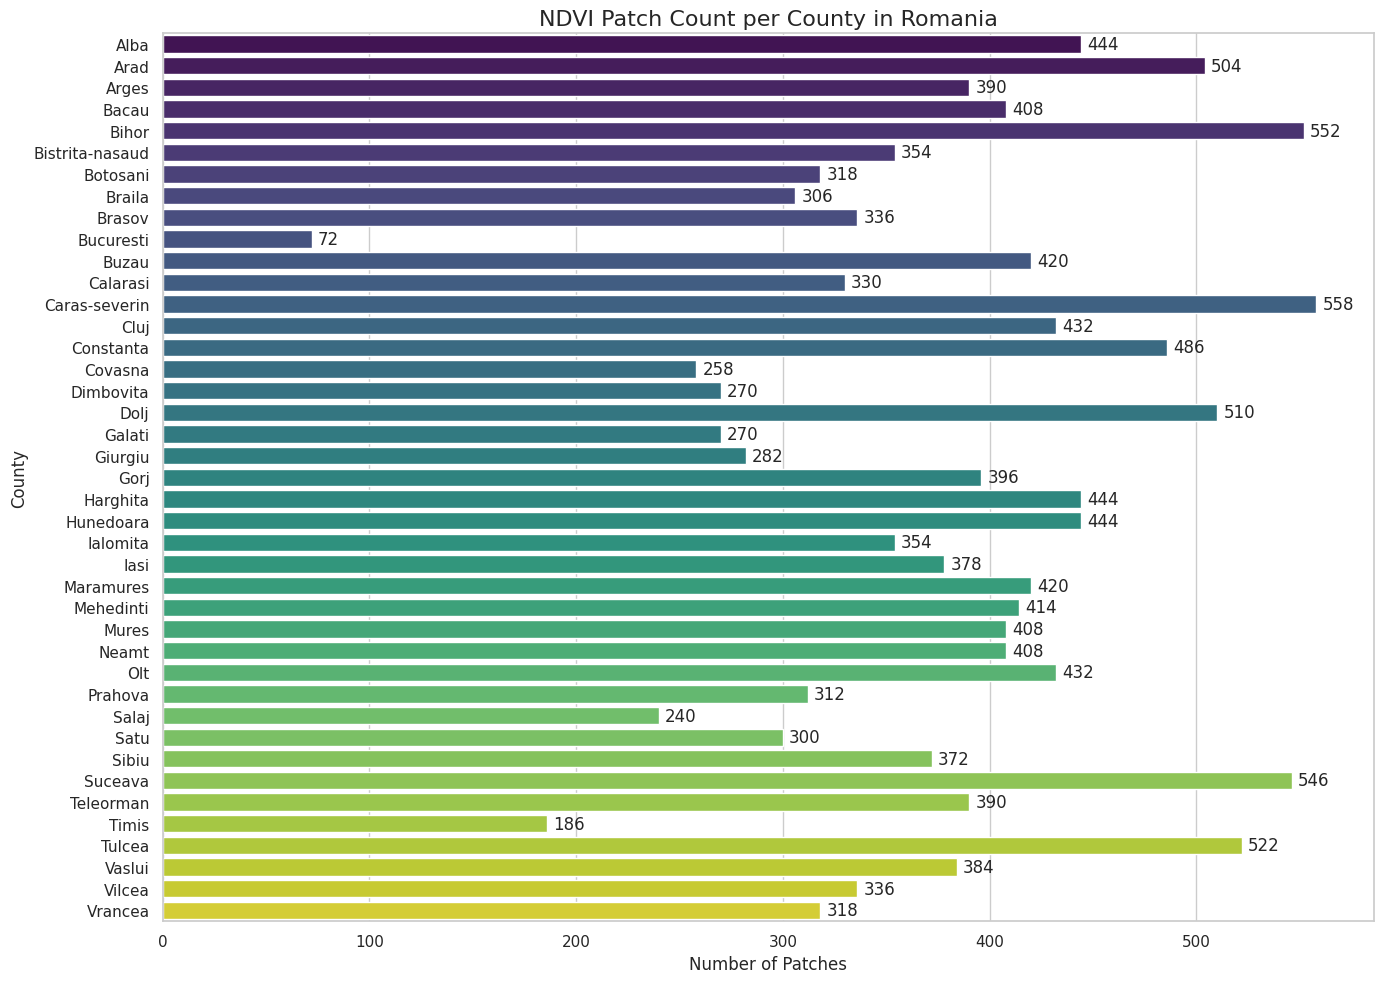

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the dataframe manually
data = {
    "County": [
        "Alba", "Arad", "Arges", "Bacau", "Bihor", "Bistrita-nasaud", "Botosani", "Braila",
        "Brasov", "Bucuresti", "Buzau", "Calarasi", "Caras-severin", "Cluj", "Constanta",
        "Covasna", "Dimbovita", "Dolj", "Galati", "Giurgiu", "Gorj", "Harghita", "Hunedoara",
        "Ialomita", "Iasi", "Maramures", "Mehedinti", "Mures", "Neamt", "Olt", "Prahova",
        "Salaj", "Satu", "Sibiu", "Suceava", "Teleorman", "Timis", "Tulcea", "Vaslui", "Vilcea", "Vrancea"
    ],
    "Patch_Count": [
        444, 504, 390, 408, 552, 354, 318, 306, 336, 72, 420, 330, 558, 432, 486,
        258, 270, 510, 270, 282, 396, 444, 444, 354, 378, 420, 414, 408, 408, 432, 312,
        240, 300, 372, 546, 390, 186, 522, 384, 336, 318
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Sort alphabetically by county
df = df.sort_values(by="County")

# Set the seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(14, 10))
barplot = sns.barplot(data=df, x="Patch_Count", y="County", palette="viridis")

# Add value labels to each bar
for index, row in df.iterrows():
    plt.text(row["Patch_Count"] + 3, index, str(row["Patch_Count"]), va='center')

# Titles and labels
plt.title("NDVI Patch Count per County in Romania", fontsize=16)
plt.xlabel("Number of Patches")
plt.ylabel("County")
plt.tight_layout()
plt.show()


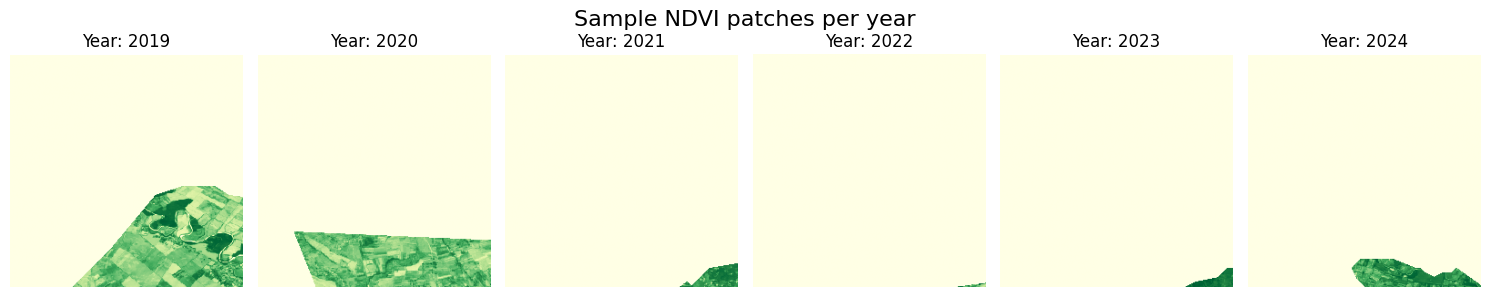

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

patch_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_patches'

years = ['2019', '2020', '2021', '2022', '2023', '2024']

# Find one patch per year (first matching file)
patches_to_show = []
for year in years:
    files = [f for f in os.listdir(patch_folder) if year in f and f.endswith('.npy')]
    if files:
        patches_to_show.append(os.path.join(patch_folder, files[0]))
    else:
        print(f"⚠️ No patch found for year {year}")

# Plot patches in a row
fig, axs = plt.subplots(1, len(patches_to_show), figsize=(15, 3))
if len(patches_to_show) == 1:
    axs = [axs]

for ax, patch_path, year in zip(axs, patches_to_show, years):
    patch = np.load(patch_path)
    im = ax.imshow(patch, cmap='YlGn', vmin=0, vmax=1)
    ax.set_title(f'Year: {year}')
    ax.axis('off')

#fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=1)
plt.suptitle("Sample NDVI patches per year", fontsize=16)
plt.tight_layout()
plt.show()


<ipython-input-47-ec23db0a12c6>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x='County', y='Patch Count', palette='viridis')
<ipython-input-47-ec23db0a12c6>:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


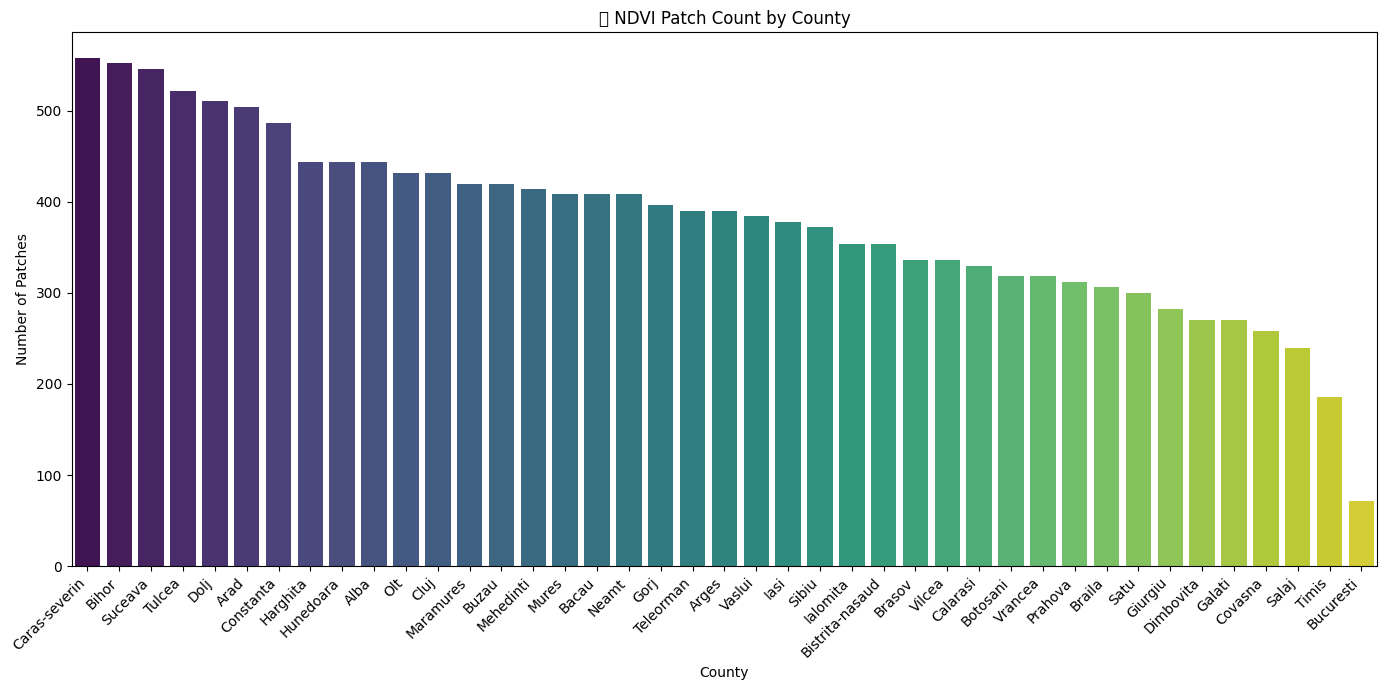

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Define patch folder
patch_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_patches'

# Initialize dictionary to count patches by county
county_patch_count = defaultdict(int)

# Traverse all files in patch folder
for fname in os.listdir(patch_folder):
    if fname.endswith('.npy'):
        parts = fname.split('_')
        if len(parts) >= 3:
            county = parts[1]
            county_patch_count[county] += 1

# Convert to DataFrame for plotting
df_counts = pd.DataFrame({
    'County': list(county_patch_count.keys()),
    'Patch Count': list(county_patch_count.values())
}).sort_values(by='Patch Count', ascending=False)

# Plot using seaborn
plt.figure(figsize=(14, 7))
sns.barplot(data=df_counts, x='County', y='Patch Count', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('📊 NDVI Patch Count by County')
plt.xlabel('County')
plt.ylabel('Number of Patches')
plt.tight_layout()
plt.show()


binary masks by thresholding NDVI patches

In [ ]:
import os
import numpy as np

patch_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_patches'
mask_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_masks'
os.makedirs(mask_folder, exist_ok=True)

threshold = 0.3  # Adjust based on vegetation sensitivity

patch_files = [f for f in os.listdir(patch_folder) if f.endswith('.npy')]

for patch_file in patch_files:
    patch_path = os.path.join(patch_folder, patch_file)
    patch = np.load(patch_path)

    # Handle nodata as nan if needed (replace with np.nan)
    patch = np.where(np.isnan(patch), 0, patch)

    # Create mask by thresholding
    mask = (patch > threshold).astype(np.uint8)  # 1 for vegetation, 0 for non-vegetation

    # Save mask with similar name but in mask_folder
    mask_path = os.path.join(mask_folder, patch_file)
    np.save(mask_path, mask)

print(f"✅ Created masks for {len(patch_files)} patches and saved to {mask_folder}")


✅ Created masks for 15504 patches and saved to /content/drive/MyDrive/Romania_by_County/ndvi_masks


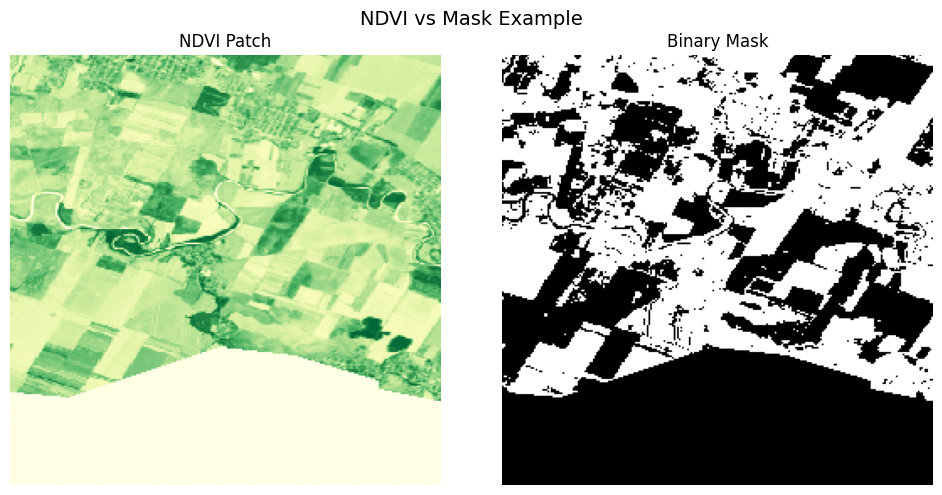

In [ ]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import os
import random

# Set paths
patch_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_patches'
mask_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_masks'

# List patch files (look for .npy instead of .tif)
patch_files = sorted([f for f in os.listdir(patch_folder) if f.endswith('.npy')])
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.npy')]) # Also look for .npy masks

# Check if there are any files before proceeding
if not patch_files or not mask_files:
    print("❌ No .npy patch or mask files found in the specified folders.")
else:
    # Pick a random sample
    sample_idx = random.randint(0, len(patch_files)-1)
    patch_path = os.path.join(patch_folder, patch_files[sample_idx])
    mask_path = os.path.join(mask_folder, mask_files[sample_idx]) # Ensure corresponding mask file is selected

    # Load NDVI patch (Need to load .npy files using np.load)
    # Replace rasterio loading with numpy loading
    ndvi = np.load(patch_path)

    # Handle potential NaN or specific nodata values if present in the .npy file
    # If you used np.where(np.isnan(patch), 0, patch) during saving, you might not have NaNs
    # If you want to mask specific values (like 0 if it represents nodata), do it here
    # For example, if 0 represents nodata and should be masked:
    # ndvi = np.where(ndvi == 0, np.nan, ndvi) # Example, adjust based on your data

    # Load mask (.npy file using np.load)
    mask = np.load(mask_path)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Use imshow with appropriate colormaps
    axs[0].imshow(ndvi, cmap='YlGn', vmin=0, vmax=1) # Adjust vmin/vmax if needed
    axs[0].set_title("NDVI Patch")
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='gray', vmin=0, vmax=1) # Assuming mask is 0 or 1
    axs[1].set_title("Binary Mask")
    axs[1].axis('off')

    plt.suptitle("NDVI vs Mask Example", fontsize=14)
    plt.tight_layout()
    plt.show()

# Section E: Time Series Comparison

- Load images for different years (e.g. 2018, 2020, 2024)

- Plot vegetation change

In [ ]:
!pip install rasterio folium matplotlib ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.6 MB/s eta 0:00:00


In [ ]:
!pip install imageio

first attemp - with folium

In [ ]:
import folium
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
from folium.raster_layers import ImageOverlay
from rasterio.enums import Resampling
from ipywidgets import Dropdown, IntSlider, Play, jslink, HBox, VBox, Button
from IPython.display import display, clear_output

# Path to your NDVI files
ndvi_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_romania_outputs'

# Build dictionary {county: [years]}
ndvi_files = sorted([f for f in os.listdir(ndvi_folder) if f.endswith('.tif')])
county_years = {}
for f in ndvi_files:
    parts = f.replace('.tif', '').split('_')
    county = '_'.join(parts[1:-1])
    year = int(parts[-1])
    county_years.setdefault(county, []).append(year)

# Widgets
county_dropdown = Dropdown(options=sorted(county_years.keys()), description="County:")
year_slider = IntSlider(description="Year")
play = Play(interval=800, description="Play", value=0)
jslink((play, 'value'), (year_slider, 'value'))

# Update year slider range when county changes
def update_slider_range(*args):
    years = sorted(county_years[county_dropdown.value])
    year_slider.min = 0
    year_slider.max = len(years) - 1
    year_slider.value = 0
    year_slider.description = f"Year ({years[0]}→{years[-1]})"
    update_map()  # Automatically load first image on change

county_dropdown.observe(update_slider_range, names='value')

# Helper to get NDVI image for selected county and year index
def update_map(*args):
    clear_output(wait=True)
    display(ui)

    county = county_dropdown.value
    years = sorted(county_years[county])
    year = years[year_slider.value]
    file_name = f"NDVI_{county}_{year}.tif"
    file_path = os.path.join(ndvi_folder, file_name)

    try:
        with rasterio.open(file_path) as src:
            ndvi = src.read(1, resampling=Resampling.bilinear)
            ndvi[ndvi == src.nodata] = np.nan
            bounds = src.bounds

            norm = np.clip((ndvi - 0) / (1 - 0), 0, 1)
            rgba = plt.cm.YlGn(norm)
            rgb = (rgba[:, :, :3] * 255).astype(np.uint8)

        center = [(bounds.top + bounds.bottom)/2, (bounds.left + bounds.right)/2]
        m = folium.Map(location=center, zoom_start=8)

        overlay = ImageOverlay(
            image=rgb,
            bounds=[[bounds.bottom, bounds.left], [bounds.top, bounds.right]],
            opacity=0.7,
            name=f'NDVI {county} {year}'
        )
        overlay.add_to(m)
        folium.LayerControl().add_to(m)

        display(m)

    except Exception as e:
        print(f"❌ Error loading {file_name}: {e}")

# Hook up change events
year_slider.observe(update_map, names='value')

# Layout UI
ui = VBox([county_dropdown, HBox([play, year_slider])])
display(ui)
update_slider_range()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!ls "/content/drive/MyDrive/Romania_by_County"


gadm41_ROU_1  ndvi_masks  ndvi_patches	ndvi_romania_outputs


second attempt - with matplotlib

Dropdown(description='Select County:', index=36, layout=Layout(width='50%'), options=('Alba', 'Arad', 'Arges',…

Button(description='🎬 Generate NDVI Timelapse', style=ButtonStyle())

<ipython-input-13-a029c5ac444c>:58: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(buf)


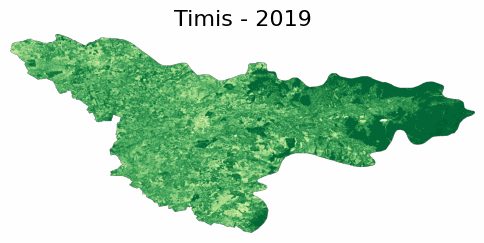

interactive(children=(IntSlider(value=0, description='Year Index', max=5), Output()), _dom_classes=('widget-in…

In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display, clear_output
from matplotlib import cm
import ipywidgets as widgets
import io

# 📁 NDVI output folder
ndvi_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_romania_outputs'
os.makedirs('/content/ndvi_timelapse', exist_ok=True)

# 📂 Collect available counties from filenames
ndvi_files = [f for f in os.listdir(ndvi_folder) if f.endswith('.tif')]
available_counties = sorted(set('_'.join(f.split('_')[1:-1]) for f in ndvi_files))

# 🎛️ County selection widget
county_dropdown = widgets.Dropdown(
    options=available_counties,
    description='Select County:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# 🎞️ Generate button
generate_button = widgets.Button(description="🎬 Generate NDVI Timelapse")

def create_ndvi_timelapse(county_name):
    files = sorted([f for f in ndvi_files if county_name in f])
    if not files:
        print(f"❌ No NDVI files found for {county_name}")
        return

    years = []
    frames = []

    for fname in files:
        path = os.path.join(ndvi_folder, fname)
        year = fname.split('_')[-1].replace('.tif', '')
        years.append(year)

        with rasterio.open(path) as src:
            ndvi = src.read(1).astype(np.float32)
            ndvi[ndvi == src.nodata] = np.nan
            norm = np.clip((ndvi - 0) / (1 - 0), 0, 1)
            rgba = cm.YlGn(norm)

            fig, ax = plt.subplots(figsize=(6, 6))
            ax.imshow(rgba)
            ax.set_title(f"{county_name} - {year}", fontsize=16)
            ax.axis('off')

            buf = io.BytesIO()
            fig.savefig(buf, format='png', bbox_inches='tight')
            buf.seek(0)
            img = imageio.imread(buf)

            frames.append(img)
            plt.close(fig)

    # 🌀 Save looping GIF with county name
    gif_path = f'/content/ndvi_timelapse/ndvi_timelapse_{county_name}.gif'
    imageio.mimsave(gif_path, frames, duration=1.0, loop=0)

    # 📽️ Display timelapse
    display(Image(filename=gif_path))

    # ⏮️ Interactive slider to browse years
    def show_year_frame(index):
        year = years[index]
        display(Image(data=imageio.imwrite('<bytes>', frames[index], format='png')))
        print(f"🗓️ Year: {year}")

    slider = widgets.IntSlider(min=0, max=len(frames)-1, step=1, description='Year Index')
    widgets.interact(show_year_frame, index=slider)

    # 🔗 Download link
    #print(f"📥 Download your NDVI timelapse for {county_name}:")
    #display(widgets.HTML(f"<a href='{gif_path}' download>⬇️ Download GIF</a>"))

# 🔘 Callback for the button
def on_generate_click(b):
    clear_output(wait=True)
    display(county_dropdown, generate_button)
    create_ndvi_timelapse(county_dropdown.value)

# 🔄 Bind event
generate_button.on_click(on_generate_click)

# 🎛️ Display controls
display(county_dropdown, generate_button)


i am thinking to also try with leafmap

# Section D: GIS Integration

- Aggregate results by county

- Generate colored maps

- Tables with % vegetation cover

prediction visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    for i in range(num_samples):
        image, mask = dataset[i]
        image = image.to(device).unsqueeze(0)
        with torch.no_grad():
            pred = model(image)
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()
            pred_bin = (pred > 0.5).astype(np.uint8)

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(image.squeeze(), cmap='gray')
        axs[0].set_title("NDVI")
        axs[1].imshow(mask.squeeze(), cmap='gray')
        axs[1].set_title("True Mask")
        axs[2].imshow(pred_bin, cmap='gray')
        axs[2].set_title("Predicted")
        for ax in axs:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Example:
visualize_predictions(model, val_dataset, device=device)


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = df.sort_values("County")  # Ensure alphabetical order
plt.figure(figsize=(14,6))
sns.barplot(data=df, x="County", y="Vegetation_Pct", palette="Greens_d")
plt.xticks(rotation=90)
plt.title("Vegetation Coverage (%) per County")
plt.ylabel("Vegetation %")
plt.xlabel("County")
plt.tight_layout()
plt.show()


Romanian Map with Vegetation Percentages per County

<Figure size 1200x1000 with 0 Axes>

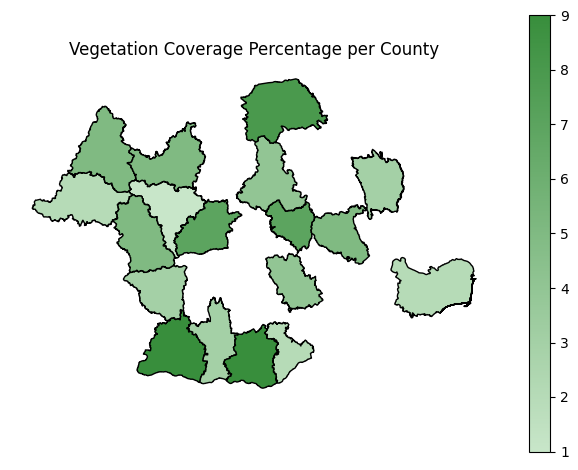

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # Import mcolors to create custom colormaps

# Load a Romanian county shapefile (must match your county names)
romania_map = gpd.read_file("/content/drive/MyDrive/Romania_by_County/gadm41_ROU_1/gadm41_ROU_1.shp")

# Ensure county names match your DataFrame
veg_df = pd.DataFrame({
    'County': ["Alba", "Arad", "Arges", "Bacau", "Bihor", "Bistrita-nasaud", "Botosani", "Braila",
        "Brasov", "Bucuresti", "Buzau", "Calarasi", "Caras-severin", "Cluj", "Constanta",
        "Covasna", "Dimbovita", "Dolj", "Galati", "Giurgiu", "Gorj", "Harghita", "Hunedoara",
        "Ialomita", "Iasi", "Maramures", "Mehedinti", "Mures", "Neamt", "Olt", "Prahova",
        "Salaj", "Satu", "Sibiu", "Suceava", "Teleorman", "Timis", "Tulcea", "Vaslui", "Vilcea", "Vrancea"],  # Your counties
    'Vegetation_Pct': [1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5 ]  # Your vegetation %
})

# Assuming the county name column is 'NAME_1' in your shapefile
# Rename the county column in romania_map to 'County' for consistency before merging
# If your shapefile's county column is already named 'County', you can remove this line.
romania_map = romania_map.rename(columns={'NAME_1': 'County'}) # Change 'NAME_1' if needed

# Ensure county names match for merging by converting to lowercase
romania_map['County'] = romania_map['County'].str.lower()
veg_df['County'] = veg_df['County'].str.lower()

# Merge shapefile with vegetation data
choropleth = romania_map.merge(veg_df, on='County', how='left')

# Create a custom colormap from pale green to dark green
# Define the colors: start with a light green, end with a dark green
colors = ["#C8E6C9", "#388E3C"] # Example hex codes for light green and dark green
cmap = mcolors.LinearSegmentedColormap.from_list("pale_to_dark_green", colors)


# Plot
plt.figure(figsize=(12, 10))
# Use the custom colormap 'cmap'
choropleth.plot(column='Vegetation_Pct', cmap=cmap, legend=True, edgecolor='black')
plt.title("Vegetation Coverage Percentage per County")
plt.axis('off')
plt.tight_layout()
plt.show()

new plan:
- NDVI-to-mask conversion for full counties

- Mask visualization side-by-side with NDVI

- Vegetation percentage calculator

- Aggregated DataFrame + export to CSV

- Static map + dynamic leafmap version

NDVI-to-MASK

In [ ]:
import os
import numpy as np
import rasterio

# Input NDVI folder
ndvi_folder = '/content/drive/MyDrive/Romania_by_County/ndvi_romania_outputs'

# Output folder for vegetation masks (outside Romania_by_County)
# Corrected path: Use 'MyDrive' instead of 'Mydrive'
mask_output_folder = '/content/drive/MyDrive/ndvi_masks'
os.makedirs(mask_output_folder, exist_ok=True)

# Years and NDVI threshold
years = [str(y) for y in range(2019, 2025)]
NDVI_THRESHOLD = 0.3

# Collect unique counties from filenames
ndvi_files = [f for f in os.listdir(ndvi_folder) if f.endswith('.tif')]
# Ensure county names are extracted correctly, handling potential multiple underscores
# The original code assumes county name is parts[1:-1], which works for NDVI_County_Year.tif
# If county names contain underscores like 'Bistrita-nasaud', this should still work.
available_counties = sorted(list(set('_'.join(f.split('_')[1:-1]) for f in ndvi_files)))


# Function to convert NDVI → binary vegetation mask
def convert_all_ndvi_to_masks():
    for county in available_counties:
        for year in years:
            # Reconstruct filename based on known structure
            input_filename = f'NDVI_{county}_{year}.tif'
            input_path = os.path.join(ndvi_folder, input_filename)
            output_path = os.path.join(mask_output_folder, f'MASK_{county}_{year}.tif')

            if not os.path.exists(input_path):
                print(f"⚠️ Skipping (missing): {input_filename}")
                continue

            try:
                with rasterio.open(input_path) as src:
                    # Read data and convert to float32
                    ndvi = src.read(1).astype(np.float32)
                    meta = src.meta.copy()

                    # Get nodata value, if present
                    nodata_val = src.nodata

                    # Create mask: 1 where NDVI > threshold AND not nodata, 0 otherwise
                    # Handle potential floating point comparisons with nodata if necessary,
                    # but for simple float nodata values and typical NDVI ranges, direct comparison is usually fine.
                    if nodata_val is not None:
                         mask = np.where((ndvi > NDVI_THRESHOLD) & (ndvi != nodata_val), 1, 0).astype(np.uint8)
                    else:
                         # If no nodata specified, just threshold
                         mask = np.where(ndvi > NDVI_THRESHOLD, 1, 0).astype(np.uint8)


                    # Update metadata for the new mask file
                    meta.update(dtype=rasterio.uint8, count=1, nodata=0) # Set nodata for the mask to 0 if desired

                    with rasterio.open(output_path, 'w', **meta) as dst:
                        dst.write(mask, 1)

                print(f"✅ Saved: {output_path}")
            except Exception as e:
                print(f"❌ Error for {input_filename}: {e}")

# Run the batch process
convert_all_ndvi_to_masks()

✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Alba_2019.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Alba_2020.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Alba_2021.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Alba_2022.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Alba_2023.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Alba_2024.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Arad_2019.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Arad_2020.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Arad_2021.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Arad_2022.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Arad_2023.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Arad_2024.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Arges_2019.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Arges_2020.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Arges_2021.tif
✅ Saved: /content/drive/MyDrive/ndvi_masks/MASK_Arges_2022.tif
✅ Sa

 NDVI || Mask Visualization and Comparison

In [ ]:
!pip install ipywidgets --quiet
from google.colab import output
output.enable_custom_widget_manager()


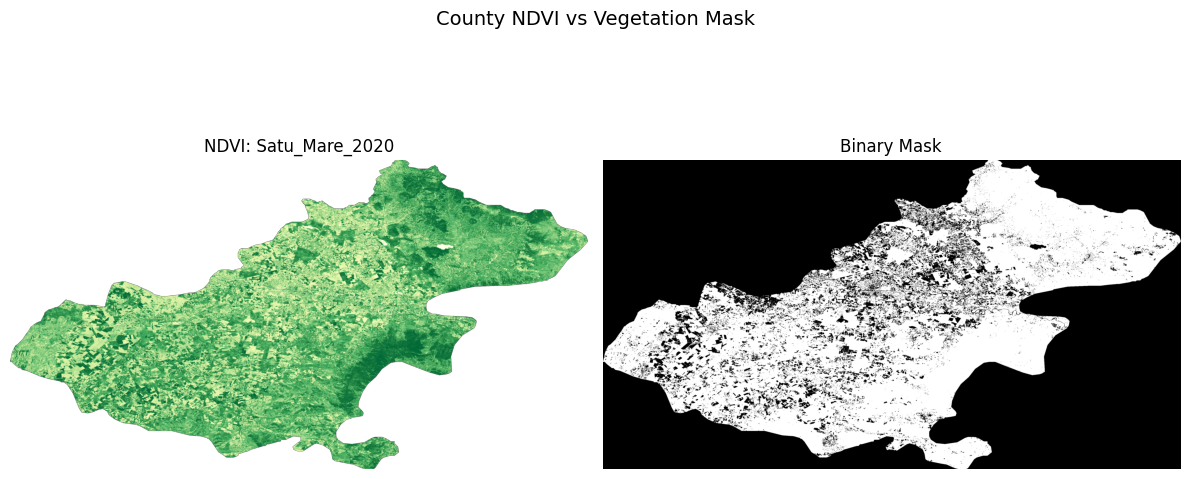

In [ ]:
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import os
import random

# Set paths
ndvi_dir = '/content/drive/MyDrive/Romania_by_County/ndvi_romania_outputs'
mask_dir = '/content/drive/MyDrive/ndvi_masks'

# List files
ndvi_files = sorted([f for f in os.listdir(ndvi_dir) if f.startswith('NDVI_') and f.endswith('.tif')])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.startswith('MASK_') and f.endswith('.tif')])

if not ndvi_files or not mask_files:
    print("❌ No .tif NDVI or mask files found in the specified folders.")
else:
    # Pick a random NDVI file
    ndvi_file = random.choice(ndvi_files)

    # Extract county/year info to find matching mask
    base_name = ndvi_file.replace('NDVI_', '')
    mask_file = f'MASK_{base_name}'

    ndvi_path = os.path.join(ndvi_dir, ndvi_file)
    mask_path = os.path.join(mask_dir, mask_file)

    # Double check mask exists
    if not os.path.exists(mask_path):
        print(f"⚠️ No matching mask found for {ndvi_file}")
    else:
        # Load NDVI
        with rasterio.open(ndvi_path) as src:
            ndvi = src.read(1).astype(np.float32)
            ndvi[ndvi == src.nodata] = np.nan  # Handle nodata if present

        # Load mask
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        axs[0].imshow(ndvi, cmap='YlGn', vmin=0, vmax=1)
        axs[0].set_title(f"NDVI: {base_name.replace('.tif','')}")
        axs[0].axis('off')

        axs[1].imshow(mask, cmap='gray', vmin=0, vmax=1)
        axs[1].set_title("Binary Mask")
        axs[1].axis('off')

        plt.suptitle("County NDVI vs Vegetation Mask", fontsize=14)
        plt.tight_layout()
        plt.show()


Compute % vegetation coverage from the mask

<ipython-input-6-8e2565d7b1f2>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-6-8e2565d7b1f2>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-6-8e2565d7b1f2>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-6-8e2565d7b1f2>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-6-8e2565d7b1f2>:52: FutureWarning: 

Passing `palette

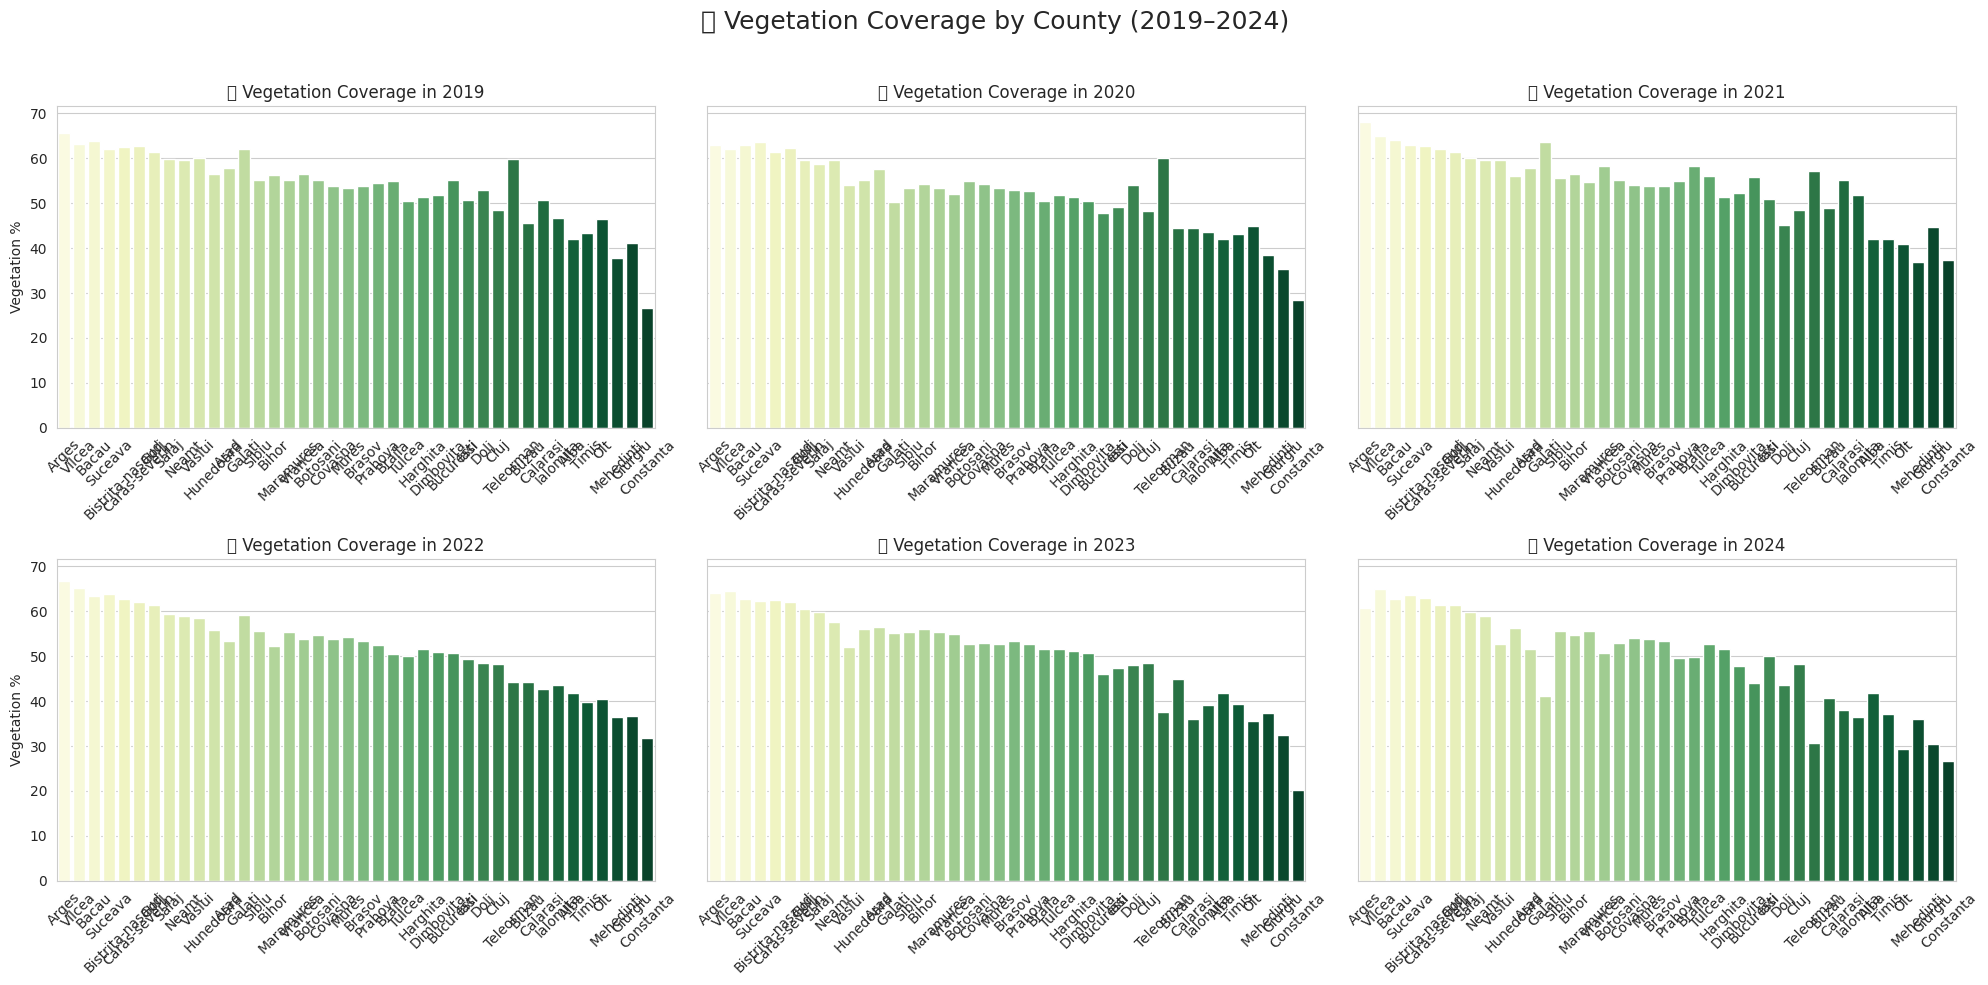

In [ ]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Paths
mask_dir = '/content/drive/MyDrive/ndvi_masks'

# Initialize: year -> county -> vegetation %
yearly_data = defaultdict(lambda: defaultdict(float))

# Traverse mask files
for fname in os.listdir(mask_dir):
    if fname.endswith('.tif') and fname.startswith('MASK_'):
        parts = fname.replace('.tif', '').split('_')
        if len(parts) == 3:
            _, county, year = parts

            # Read mask using rasterio
            mask_path = os.path.join(mask_dir, fname)
            with rasterio.open(mask_path) as src:
                mask = src.read(1)  # First band

            # Clean mask (assumes vegetation is 1, non-veg is 0)
            mask = np.nan_to_num(mask)
            total = mask.size
            veg = np.sum(mask == 1)

            veg_percent = (veg / total) * 100
            yearly_data[int(year)][county] = veg_percent

# Convert to DataFrame
all_records = []
for year, counties in yearly_data.items():
    for county, percentage in counties.items():
        all_records.append({'Year': year, 'County': county, 'Vegetation %': percentage})

df = pd.DataFrame(all_records)

# Sort counties for consistency across years
county_order = df.groupby('County')['Vegetation %'].mean().sort_values(ascending=False).index

# Plotting
sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
axs = axs.flatten()

for i, year in enumerate(sorted(df['Year'].unique())):
    sns.barplot(
        data=df[df['Year'] == year],
        x='County', y='Vegetation %', ax=axs[i],
        order=county_order,
        palette='YlGn'
    )
    axs[i].set_title(f'🌱 Vegetation Coverage in {year}')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Vegetation %')
    axs[i].tick_params(axis='x', rotation=45)

plt.suptitle('🌿 Vegetation Coverage by County (2019–2024)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


<ipython-input-4-fa36cfdf1922>:68: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


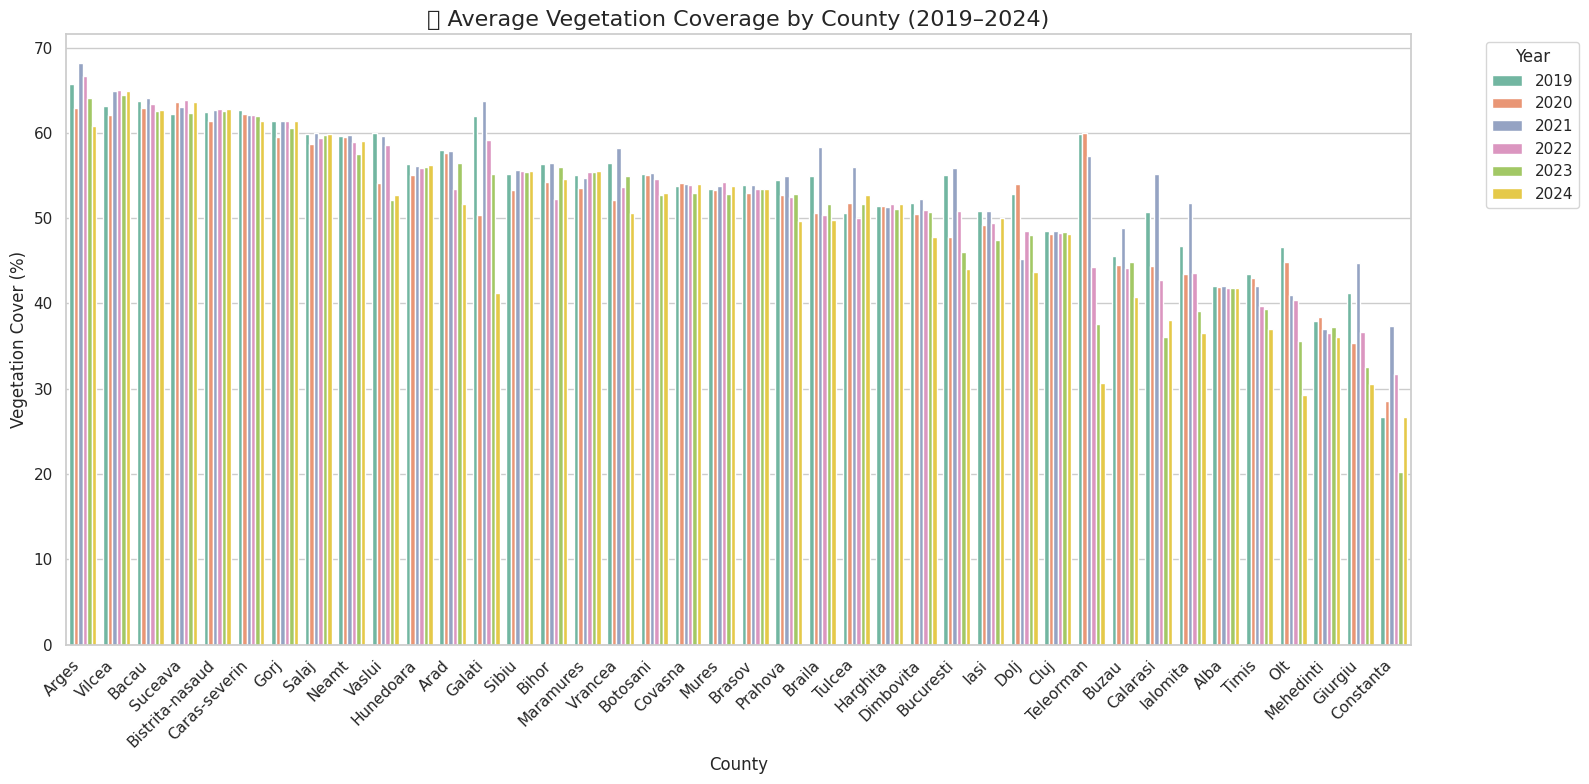

In [ ]:
import os
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Paths
mask_dir = '/content/drive/MyDrive/ndvi_masks'

# Prepare data
records = []

# Process each mask file
for fname in os.listdir(mask_dir):
    if fname.endswith('.tif') and fname.startswith('MASK_'):
        parts = fname.replace('.tif', '').split('_')
        if len(parts) == 3:
            _, county, year = parts
            year = int(year)

            mask_path = os.path.join(mask_dir, fname)
            with rasterio.open(mask_path) as src:
                mask = src.read(1)

            # Clean and compute vegetation %
            mask = np.nan_to_num(mask)
            total_pixels = mask.size
            veg_pixels = np.sum(mask == 1)
            veg_percent = (veg_pixels / total_pixels) * 100

            records.append({
                'County': county,
                'Year': year,
                'Vegetation %': veg_percent
            })

# Create DataFrame
df = pd.DataFrame(records)

# Sort counties by mean vegetation (for consistent order)
county_order = df.groupby('County')['Vegetation %'].mean().sort_values(ascending=False).index

# Plot
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")

# Use seaborn's color_palette for distinct year colors
palette = sns.color_palette("Set2", n_colors=df['Year'].nunique())

# Create barplot
sns.barplot(
    data=df,
    x='County',
    y='Vegetation %',
    hue='Year',
    order=county_order,
    palette=palette
)

# Aesthetics
plt.title('🌿 Average Vegetation Coverage by County (2019–2024)', fontsize=16)
plt.xlabel('County')
plt.ylabel('Vegetation Cover (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
print(sorted(set(df['County'])))


['Alba', 'Arad', 'Arges', 'Bacau', 'Bihor', 'Bistrita-nasaud', 'Botosani', 'Braila', 'Brasov', 'Bucuresti', 'Buzau', 'Calarasi', 'Caras-severin', 'Cluj', 'Constanta', 'Covasna', 'Dimbovita', 'Dolj', 'Galati', 'Giurgiu', 'Gorj', 'Harghita', 'Hunedoara', 'Ialomita', 'Iasi', 'Maramures', 'Mehedinti', 'Mures', 'Neamt', 'Olt', 'Prahova', 'Salaj', 'Sibiu', 'Suceava', 'Teleorman', 'Timis', 'Tulcea', 'Vaslui', 'Vilcea', 'Vrancea']


In [ ]:
# County | Year | Vegetation %
# Sort by County and Year
df_sorted = df.sort_values(by=['County', 'Year'])

# Reset index for clean display (optional)
df_sorted.reset_index(drop=True, inplace=True)

# Display first few rows (across all counties, in order)
print(df_sorted.head(241))  # Adjust number as needed


      County  Year  Vegetation %
0       Alba  2019     42.107935
1       Alba  2020     41.941251
2       Alba  2021     42.034173
3       Alba  2022     41.851493
4       Alba  2023     41.791739
..       ...   ...           ...
235  Vrancea  2020     52.121090
236  Vrancea  2021     58.262113
237  Vrancea  2022     53.718406
238  Vrancea  2023     54.977184
239  Vrancea  2024     50.622654

[240 rows x 3 columns]


Satu Mare is missing.....

In [ ]:
for fname in os.listdir(mask_dir):
    if fname.endswith('.tif') and fname.startswith('MASK_'):
        parts = fname.replace('.tif', '').split('_')
        if len(parts) >= 3:
            *_, year_str = parts
            year = int(year_str)
            county = '_'.join(parts[1:-1]).replace('_', ' ').strip().title()

            mask_path = os.path.join(mask_dir, fname)
            with rasterio.open(mask_path) as src:
                mask = src.read(1)

            mask = np.nan_to_num(mask)
            total_pixels = mask.size
            veg_pixels = np.sum(mask == 1)
            veg_percent = (veg_pixels / total_pixels) * 100

            records.append({
                'County': county,
                'Year': year,
                'Vegetation %': veg_percent
            })


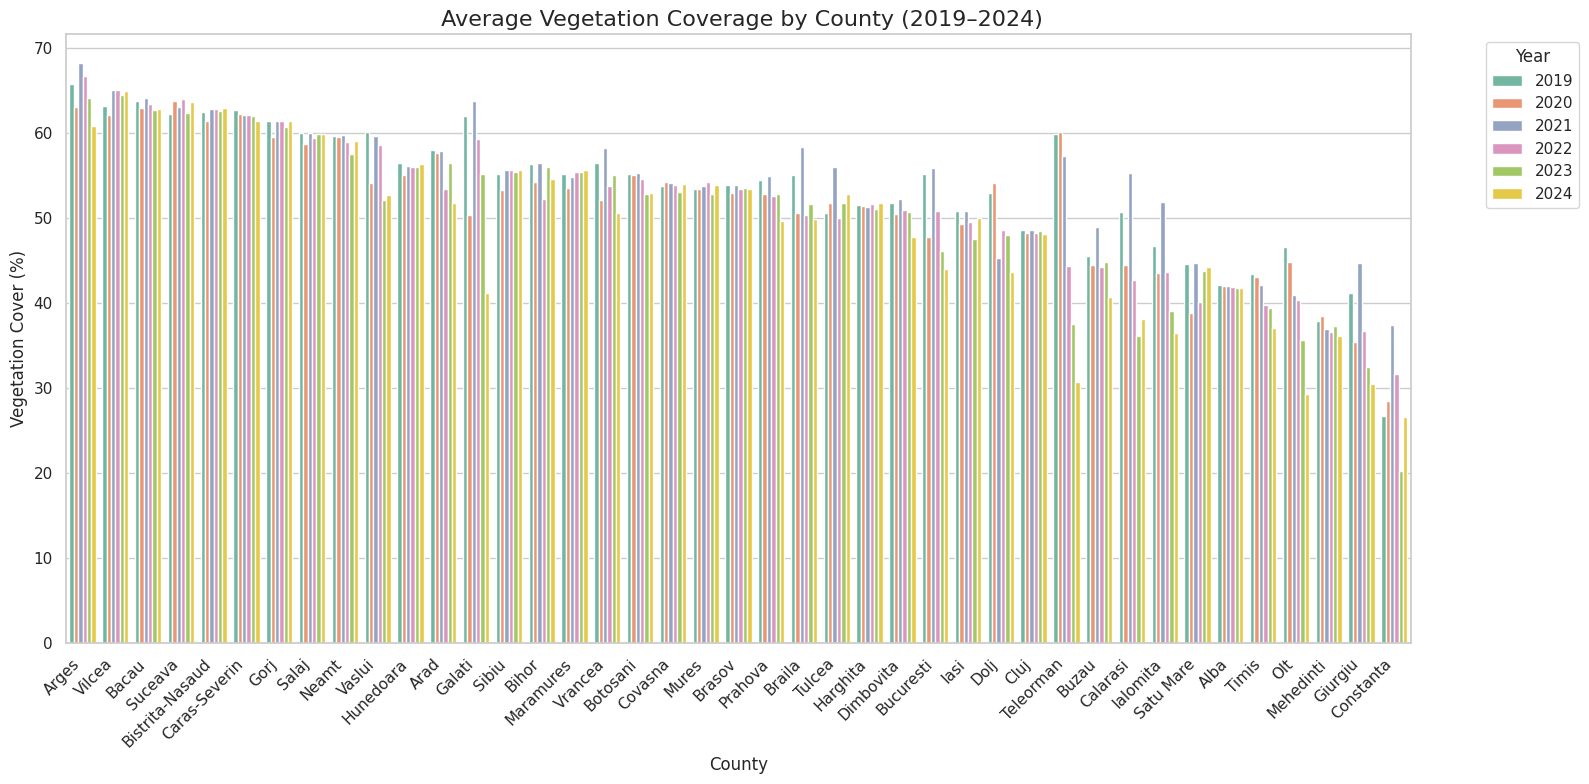

In [ ]:
import os
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the directory containing MASK_*.tif files
mask_dir = '/content/drive/MyDrive/ndvi_masks'

# Prepare list to store data
records = []

# Loop through each file in the directory
for fname in os.listdir(mask_dir):
    if fname.endswith('.tif') and fname.startswith('MASK_'):
        # Remove extension and split by underscore
        parts = fname.replace('.tif', '').split('_')

        if len(parts) >= 3:
            # Last part is the year
            year_str = parts[-1]
            try:
                year = int(year_str)
            except ValueError:
                continue  # Skip files where year isn't an integer

            # Join everything between MASK and year as county name
            county_raw = '_'.join(parts[1:-1])
            county = county_raw.replace('_', ' ').strip().title()

            # Read mask file
            mask_path = os.path.join(mask_dir, fname)
            with rasterio.open(mask_path) as src:
                mask = src.read(1)

            # Clean and compute vegetation %
            mask = np.nan_to_num(mask)
            total_pixels = mask.size
            veg_pixels = np.sum(mask == 1)
            veg_percent = (veg_pixels / total_pixels) * 100

            # Append to records
            records.append({
                'County': county,
                'Year': year,
                'Vegetation %': veg_percent
            })

# Convert to DataFrame
df = pd.DataFrame(records)

# Sort counties by mean vegetation percentage for better plot order
county_order = df.groupby('County')['Vegetation %'].mean().sort_values(ascending=False).index

# Plotting
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")

# Distinct colors for each year
palette = sns.color_palette("Set2", n_colors=df['Year'].nunique())

# Create the barplot
sns.barplot(
    data=df,
    x='County',
    y='Vegetation %',
    hue='Year',
    order=county_order,
    palette=palette
)

# Aesthetics
plt.title(' Average Vegetation Coverage by County (2019–2024)', fontsize=16)
plt.xlabel('County')
plt.ylabel('Vegetation Cover (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Section F: Forecasting (prediction models discussion)

Linear trends per county & Potential future prediction using:
- regression models,

- time series forecasting (ARIMA, Prophet),

- Random Forests,

- unsupervised learning (e.g., clustering counties by trends)

Models:
- Linear Regression (baseline)

- ARIMA (time series modeling)

- Random Forest Regressor (for nonlinear patterns)

- (Optional) Prophet from Meta (very good for seasonal patterns, Colab-friendly)


PLAN:
1. Load vegetation masks (.tif)
2. Compute % vegetation per county per year
3. Build structured dataset
4. Visualize historical trends
5. Train predictive models
6. Predict future vegetation coverage
7. Analyze results (with graphs & errors)
8. Discuss implications, limitations


## LINEAR REGRESSION

Encode and prepare data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. One-hot encode the counties
df_encoded = pd.get_dummies(df, columns=['County'], drop_first=True)

# 2. Define features and target
X = df_encoded.drop(columns=['Vegetation %'])
y = df_encoded['Vegetation %']

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Fit Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# 5. Predict
y_pred = model_lr.predict(X_test)

# 6. Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Linear Regression Results:
MAE: 3.09
RMSE: 4.49
R²: 0.66


visualization

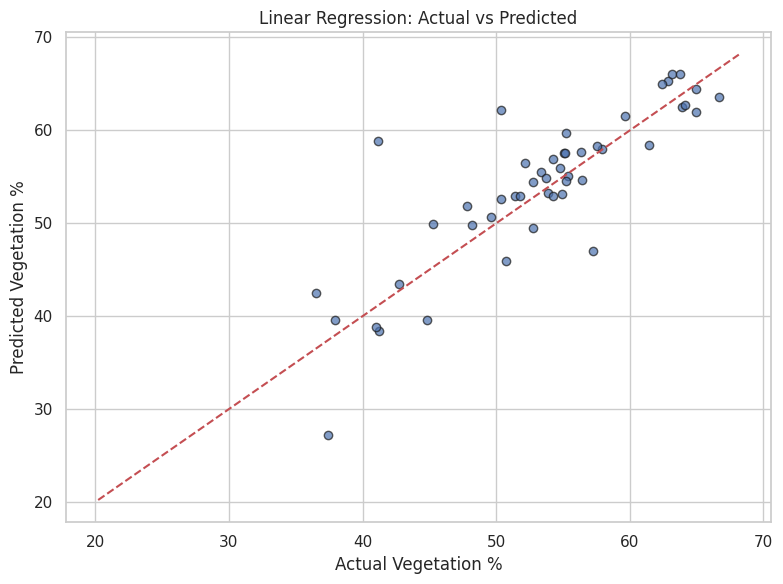

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Vegetation %")
plt.ylabel("Predicted Vegetation %")
plt.title("Linear Regression: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


## Random Forest Regression per County

       County  Year  Actual Vegetation %  Predicted Vegetation %  R2 Train
35      Timis  2024            37.058681               39.758092  0.958016
34  Teleorman  2024            30.716851               41.067871  0.946648
29        Olt  2024            29.284783               37.375494  0.936898
28      Neamt  2024            59.004941               58.100494  0.901718
6    Botosani  2024            52.899566               53.448294  0.889097


<ipython-input-18-01b6eb8d1b58>:52: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


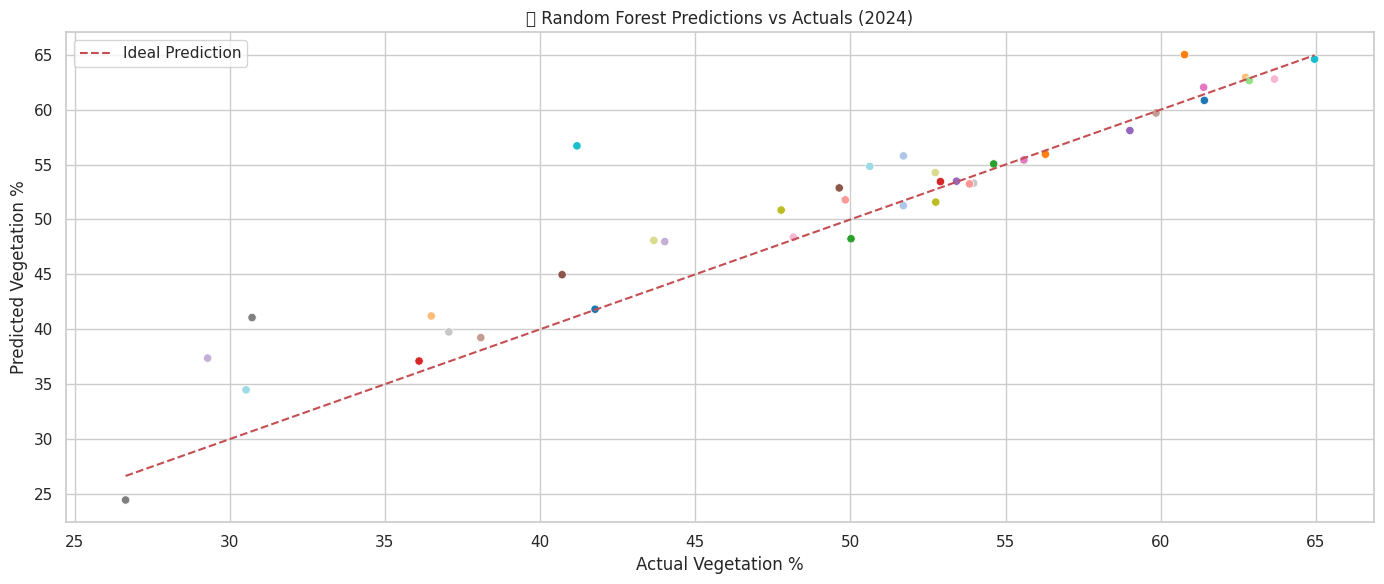

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare a dictionary to store results
rf_results = []

# Loop over each county
for county in sorted(df['County'].unique()):
    county_df = df[df['County'] == county].sort_values('Year')

    X = county_df[['Year']].values
    y = county_df['Vegetation %'].values

    if len(X) < 5:
        print(f"Skipping {county} (not enough data)")
        continue

    # Train on all years except the last
    X_train, y_train = X[:-1], y[:-1]
    X_test, y_test = X[-1:], y[-1:]  # predict the most recent year

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rf_results.append({
        'County': county,
        'Year': X_test[0][0],
        'Actual Vegetation %': y_test[0],
        'Predicted Vegetation %': y_pred[0],
        'R2 Train': model.score(X_train, y_train)
    })

# Convert results to DataFrame
df_rf_results = pd.DataFrame(rf_results)

# Display
print(df_rf_results.sort_values('R2 Train', ascending=False).head())

# Plot predicted vs actual
plt.figure(figsize=(14, 6))
sns.scatterplot(data=df_rf_results, x='Actual Vegetation %', y='Predicted Vegetation %', hue='County', palette='tab20', legend=False)
plt.plot([df_rf_results['Actual Vegetation %'].min(), df_rf_results['Actual Vegetation %'].max()],
         [df_rf_results['Actual Vegetation %'].min(), df_rf_results['Actual Vegetation %'].max()],
         'r--', label='Ideal Prediction')
plt.title('🌲 Random Forest Predictions vs Actuals (2024)')
plt.xlabel('Actual Vegetation %')
plt.ylabel('Predicted Vegetation %')
plt.legend()
plt.tight_layout()
plt.show()


## XGBoost Regression

In [ ]:
!pip install xgboost


       County  Year  Actual Vegetation %  Predicted Vegetation %  R2 Train
34  Teleorman  2024            30.716851               37.554501       1.0
11   Calarasi  2024            38.088653               36.080513       1.0
14  Constanta  2024            26.641398               20.221149       1.0
29        Olt  2024            29.284783               35.623814       1.0
19    Giurgiu  2024            30.523897               32.530785       1.0


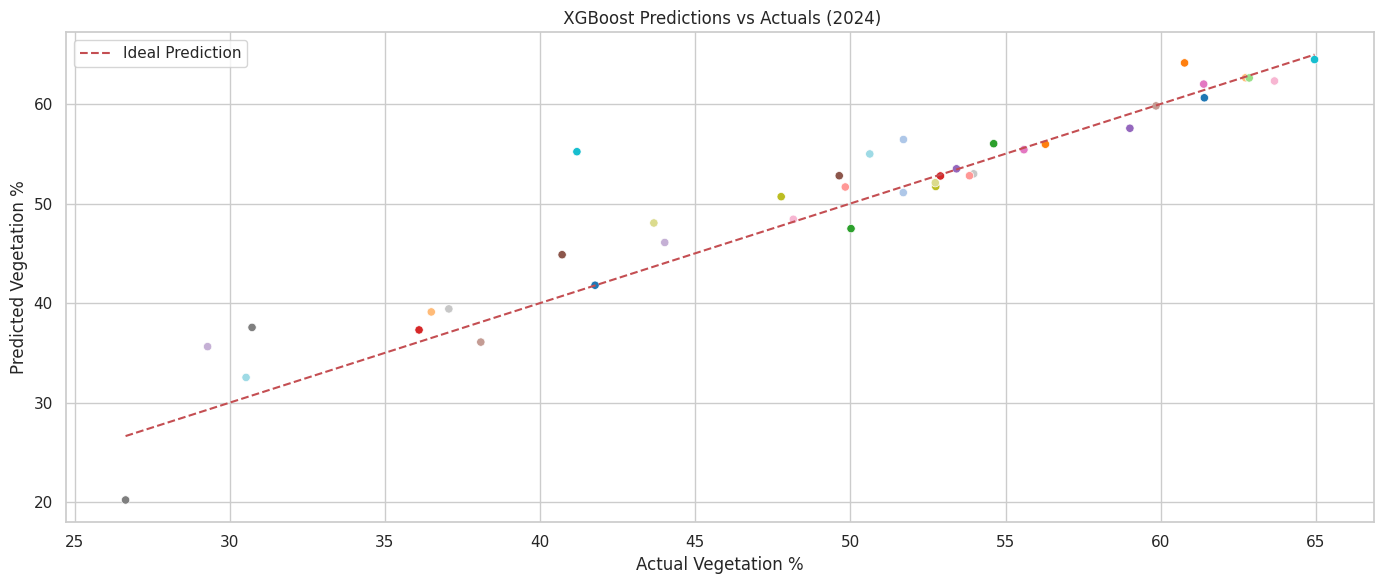

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Store results
xgb_results = []

# Per-county training
for county in sorted(df['County'].unique()):
    county_df = df[df['County'] == county].sort_values('Year')

    X = county_df[['Year']].values
    y = county_df['Vegetation %'].values

    if len(X) < 5:
        print(f"Skipping {county} (not enough data)")
        continue

    X_train, y_train = X[:-1], y[:-1]
    X_test, y_test = X[-1:], y[-1:]

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    xgb_results.append({
        'County': county,
        'Year': X_test[0][0],
        'Actual Vegetation %': y_test[0],
        'Predicted Vegetation %': y_pred[0],
        'R2 Train': model.score(X_train, y_train)
    })

# Results DataFrame
df_xgb_results = pd.DataFrame(xgb_results)

# Print top counties
print(df_xgb_results.sort_values('R2 Train', ascending=False).head())

# Plot
plt.figure(figsize=(14, 6))
sns.scatterplot(data=df_xgb_results, x='Actual Vegetation %', y='Predicted Vegetation %', hue='County', palette='tab20', legend=False)
plt.plot([df_xgb_results['Actual Vegetation %'].min(), df_xgb_results['Actual Vegetation %'].max()],
         [df_xgb_results['Actual Vegetation %'].min(), df_xgb_results['Actual Vegetation %'].max()],
         'r--', label='Ideal Prediction')
plt.title(' XGBoost Predictions vs Actuals (2024)')
plt.xlabel('Actual Vegetation %')
plt.ylabel('Predicted Vegetation %')
plt.legend()
plt.tight_layout()
plt.show()


## Prophet

In [ ]:
!pip install prophet --quiet

In [ ]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
import numpy as np
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

prophet_results = []

for county in sorted(df['County'].unique()):
    county_df = df[df['County'] == county].sort_values('Year')

    if len(county_df) < 5:
        print(f"Skipping {county} (not enough data)")
        continue

    # Prepare data for Prophet
    prophet_df = county_df[['Year', 'Vegetation %']].rename(columns={'Year': 'ds', 'Vegetation %': 'y'})
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

    # Train-test split
    train_df = prophet_df.iloc[:-1]
    test_df = prophet_df.iloc[-1:]

    model = Prophet()
    model.fit(train_df)

    # Forecast
    future = model.make_future_dataframe(periods=1, freq='Y')
    forecast = model.predict(future)

    # Extract last prediction (for test year)
    predicted_value = forecast.iloc[-1]['yhat']
    actual_value = test_df['y'].values[0]
    test_year = test_df['ds'].dt.year.values[0]

    # Accuracy metrics
    y_train = train_df['y'].values
    y_train_pred = model.predict(train_df)['yhat']
    r2 = r2_score(y_train, y_train_pred)

    # Calculate RMSE manually by taking the square root
    mse = mean_squared_error([actual_value], [predicted_value])
    rmse = np.sqrt(mse) # Calculate the square root for RMSE

    mae = mean_absolute_error([actual_value], [predicted_value])

    prophet_results.append({
        'County': county,
        'Year': test_year,
        'Actual Vegetation %': actual_value,
        'Predicted Vegetation %': predicted_value,
        'R2 Train': r2,
        'RMSE': rmse,
        'MAE': mae
    })



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph96h9h7t/tbi9oqxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph96h9h7t/jhfeb9g9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40841', 'data', 'file=/tmp/tmph96h9h7t/tbi9oqxu.json', 'init=/tmp/tmph96h9h7t/jhfeb9g9.json', 'output', 'file=/tmp/tmph96h9h7t/prophet_model3bcxgvhf/prophet_model-20250520203426.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:34:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:34:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

       County  Year  Actual Vegetation %  Predicted Vegetation %  R2 Train  \
28      Neamt  2024            59.004941               58.216760       1.0   
33    Suceava  2024            63.664084               67.035586       1.0   
25  Maramures  2024            55.589219               54.276777       1.0   
30    Prahova  2024            49.638836               53.752790       1.0   
3       Bacau  2024            62.732752               62.993836       1.0   

        RMSE       MAE  
28  0.788181  0.788181  
33  3.371502  3.371502  
25  1.312442  1.312442  
30  4.113955  4.113955  
3   0.261084  0.261084  


<ipython-input-28-af180c9d75da>:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


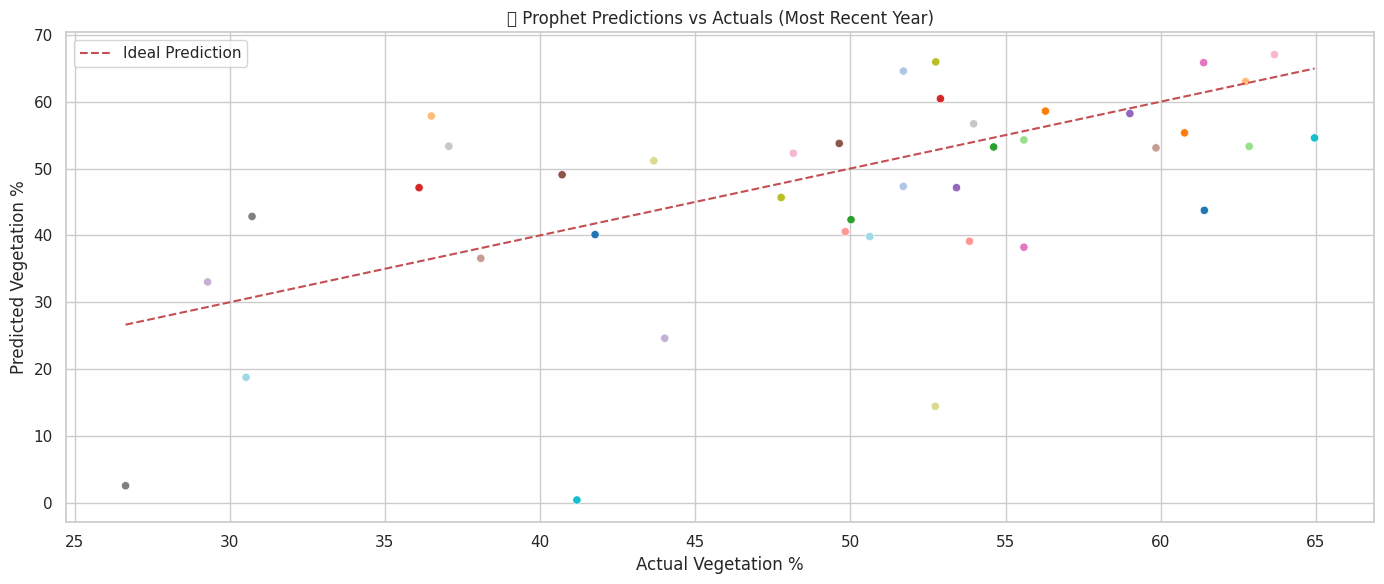

In [ ]:
df_prophet_results = pd.DataFrame(prophet_results)

print(df_prophet_results.sort_values('R2 Train', ascending=False).head())

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=df_prophet_results,
    x='Actual Vegetation %',
    y='Predicted Vegetation %',
    hue='County',
    palette='tab20',
    legend=False
)
plt.plot(
    [df_prophet_results['Actual Vegetation %'].min(), df_prophet_results['Actual Vegetation %'].max()],
    [df_prophet_results['Actual Vegetation %'].min(), df_prophet_results['Actual Vegetation %'].max()],
    'r--', label='Ideal Prediction'
)
plt.title('📈 Prophet Predictions vs Actuals (Most Recent Year)')
plt.xlabel('Actual Vegetation %')
plt.ylabel('Predicted Vegetation %')
plt.legend()
plt.tight_layout()
plt.show()


## K-Means

To capture both direct vegetation levels and the underlying dynamics, we applied K-Means clustering on:
- raw vegetation values across years
- model-based features like trend, forecast, and variability

This dual approach allows for both descriptive and inferential insights.

raw vegetation

prepare the data

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your main dataframe is `df` with columns: County, Year, Vegetation %

# Pivot data: rows=County, columns=Year, values=Vegetation %
df_pivot = df.pivot(index='County', columns='Year', values='Vegetation %')

# Check for missing values
print(df_pivot.isnull().sum())

# Fill missing values if any (simple forward fill or mean)
df_pivot_filled = df_pivot.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

# Display prepared data
print(df_pivot_filled.head())


Year
2019    0
2020    0
2021    0
2022    0
2023    0
2024    0
dtype: int64
Year         2019       2020       2021       2022       2023       2024
County                                                                  
Alba    42.107935  41.941251  42.034173  41.851493  41.791739  41.770602
Arad    57.945001  57.674418  57.868268  53.370498  56.428046  51.708015
Arges   65.709592  62.972842  68.154920  66.649287  64.120418  60.766531
Bacau   63.787373  62.881721  64.118808  63.421534  62.627857  62.732752
Bihor   56.364483  54.256044  56.428159  52.222101  56.008575  54.615383


<ipython-input-50-f08a66b2969c>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pivot_filled = df_pivot.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


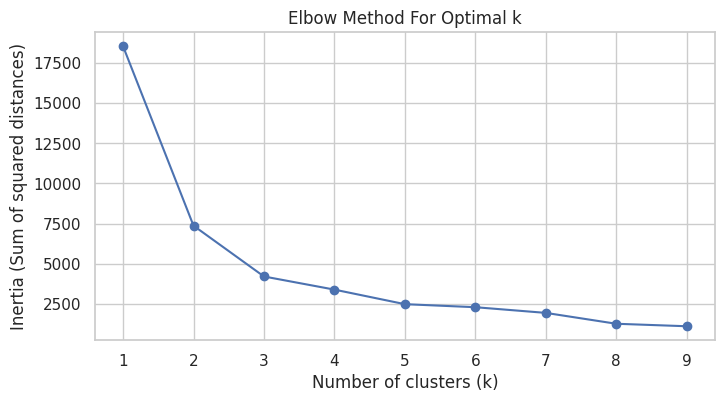

In [ ]:
# Elbow method to find optimal k
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pivot_filled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method For Optimal k')
plt.show()


In [ ]:
k = 3  # Adjust based on elbow plot

kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(df_pivot_filled)

df_pivot_filled['Cluster'] = clusters

print(df_pivot_filled[['Cluster']])


Year             Cluster
County                  
Alba                   1
Arad                   0
Arges                  2
Bacau                  2
Bihor                  0
Bistrita-Nasaud        2
Botosani               0
Braila                 0
Brasov                 0
Bucuresti              0
Buzau                  1
Calarasi               1
Caras-Severin          2
Cluj                   0
Constanta              1
Covasna                0
Dimbovita              0
Dolj                   0
Galati                 0
Giurgiu                1
Gorj                   2
Harghita               0
Hunedoara              0
Ialomita               1
Iasi                   0
Maramures              0
Mehedinti              1
Mures                  0
Neamt                  2
Olt                    1
Prahova                0
Salaj                  2
Satu Mare              1
Sibiu                  0
Suceava                2
Teleorman              1
Timis                  1
Tulcea                 0


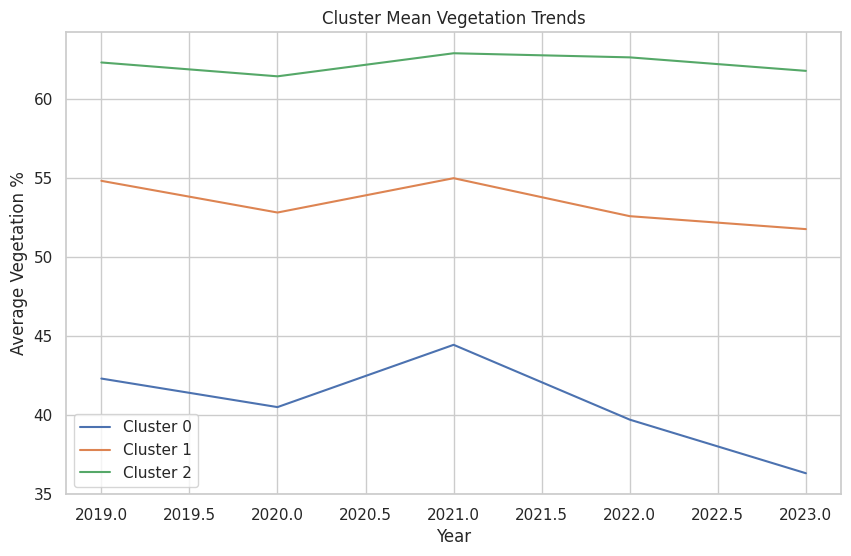

In [ ]:
cluster_means = df_pivot_filled.groupby('Cluster').mean()

plt.figure(figsize=(10,6))
for c in cluster_means.index:
    plt.plot(cluster_means.columns[:-1], cluster_means.loc[c, cluster_means.columns[:-1]], label=f'Cluster {c}')
plt.xlabel('Year')
plt.ylabel('Average Vegetation %')
plt.title('Cluster Mean Vegetation Trends')
plt.legend()
plt.show()


*The unsupervised K-Means clustering grouped Romanian counties into three distinct clusters based on their vegetation coverage trends from 2019 to 2024. The first cluster included counties with relatively stable vegetation percentages, suggesting consistent vegetation health. The second cluster showed counties with a declining trend, potentially indicating environmental stress or land use changes. The third cluster comprised counties with higher and fluctuating vegetation coverage, possibly reflecting forested or protected areas. These groupings highlight spatial-temporal patterns that could assist in region-specific environmental planning and monitoring. Mapping these clusters geographically may reveal correlations with climatic zones or human activity, providing a valuable exploratory step beyond purely predictive modeling.*

<ipython-input-38-5ec2863cb1fd>:50: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


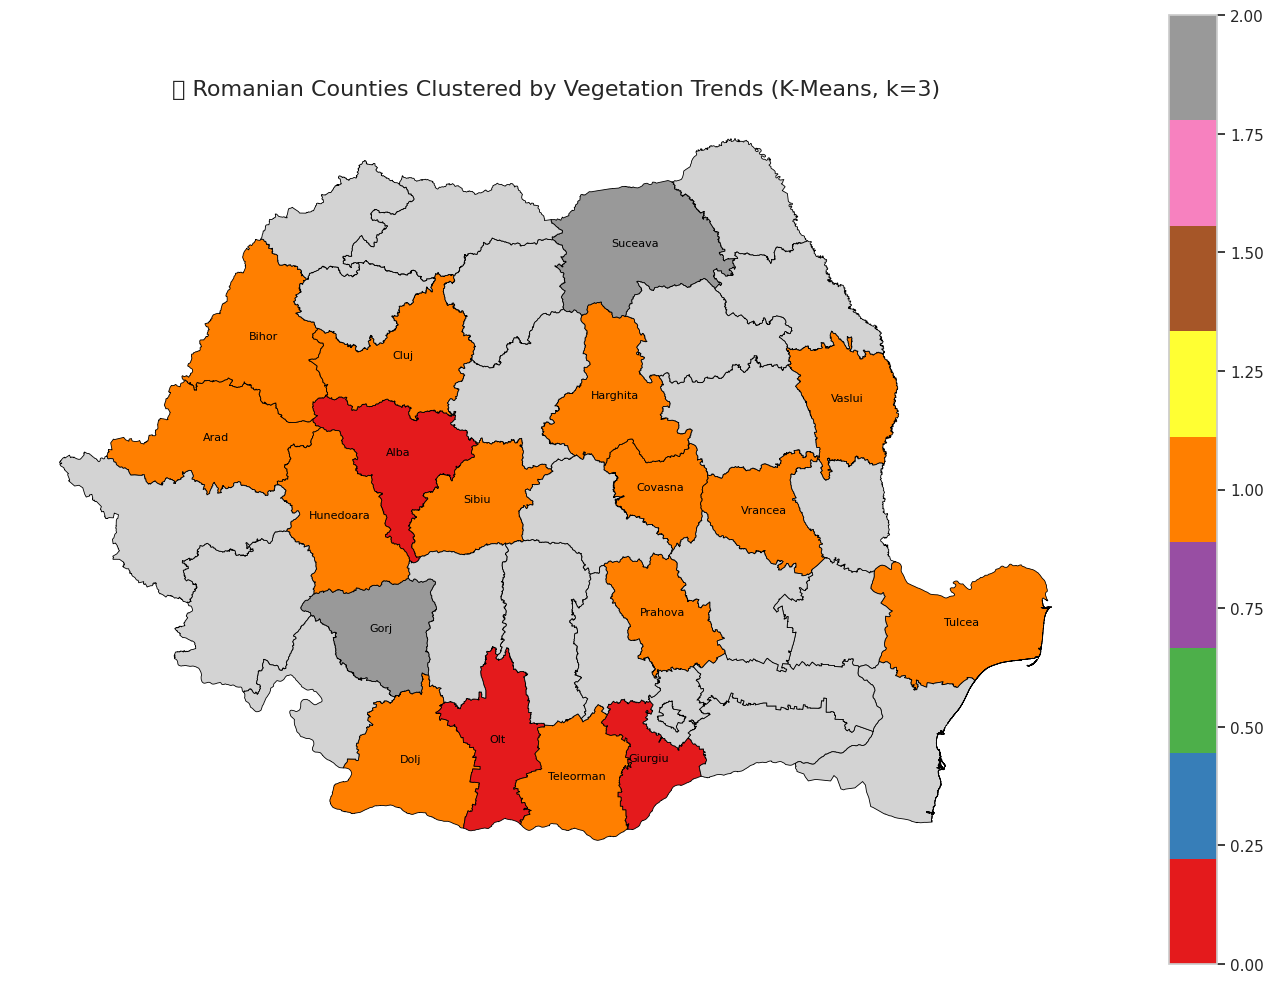

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Load Romanian counties shapefile ---
shapefile_path = '/content/drive/MyDrive/Romania_by_County/gadm41_ROU_1/gadm41_ROU_1.shp'
gdf = gpd.read_file(shapefile_path)

# Column in shapefile with county names
county_col_gdf = 'NAME_1'

# Normalize county names
gdf[county_col_gdf] = gdf[county_col_gdf].str.strip().str.title()

# --- 2. Prepare Cluster Data ---
# Assume df_pivot_filled has 'Cluster' and its index are county names
df_clusters = df_pivot_filled[['Cluster']].reset_index()
df_clusters.columns = [county_col_gdf, 'Cluster']  # Rename for easy merging
df_clusters[county_col_gdf] = df_clusters[county_col_gdf].str.strip().str.title()

# --- 3. Merge with GeoDataFrame ---
gdf_merged = gdf.merge(df_clusters, on=county_col_gdf, how='left')

# --- 4. Plot ---
fig, ax = plt.subplots(figsize=(14, 10))
gdf_merged.plot(
    column='Cluster',
    cmap='Set1',
    linewidth=0.6,
    edgecolor='black',
    legend=True,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    ax=ax
)

# Optional: Add county labels
for idx, row in gdf_merged.iterrows():
    if pd.notnull(row['Cluster']):
        plt.annotate(
            text=row[county_col_gdf],
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha='center',
            fontsize=8,
            color='black'
        )

# Styling
ax.set_title(" Romanian Counties Clustered by Vegetation Trends (K-Means, k=3)", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Which counties from shapefile are missing cluster data?
missing = gdf_merged[gdf_merged['Cluster'].isna()][county_col_gdf].tolist()
print("🚫 Counties with no cluster data (not matched):")
print(missing)


🚫 Counties with no cluster data (not matched):
['Argeș', 'Bacău', 'Bistrița-Năsăud', 'Botoșani', 'Brăila', 'Brașov', 'Bucharest', 'Buzău', 'Călărași', 'Caraș-Severin', 'Constanța', 'Dâmbovița', 'Galați', 'Ialomița', 'Iași', 'Ilfov', 'Maramureș', 'Mehedinți', 'Mureș', 'Neamț', 'Sălaj', 'Satu Mare', 'Timiș', 'Vâlcea']


Normalize

In [ ]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.5 MB/s eta 0:00:00


In [ ]:
from unidecode import unidecode

# Normalize both sides to be accent-free
gdf[county_col_gdf] = gdf[county_col_gdf].apply(unidecode)
df_clusters[county_col_gdf] = df_clusters[county_col_gdf].apply(unidecode)


In [ ]:
print(f"Matched: {gdf_merged['Cluster'].notna().sum()} / {len(gdf_merged)} counties")


Matched: 18 / 42 counties


⚠️ Unmatched counties (no cluster assigned):
- Bucharest
- Dambovita
- Ilfov
- Satu Mare
- Valcea


<ipython-input-45-91c48bb776cd>:57: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


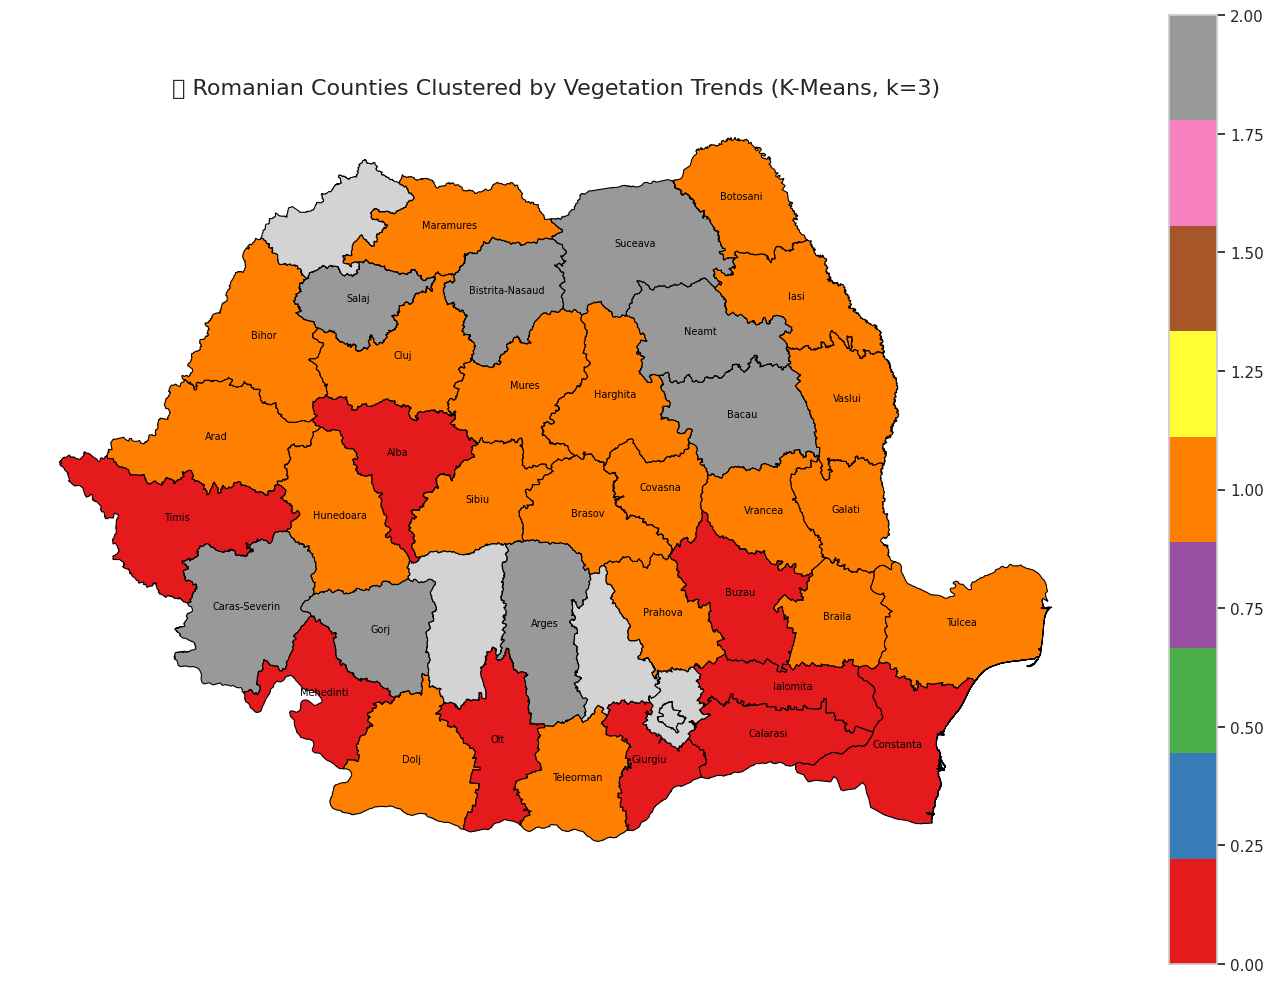

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from unidecode import unidecode

# --- 1. Load Romanian counties shapefile ---
shapefile_path = '/content/drive/MyDrive/Romania_by_County/gadm41_ROU_1/gadm41_ROU_1.shp'
gdf = gpd.read_file(shapefile_path)

county_col_gdf = 'NAME_1'  # Column in shapefile with county names

# Normalize names: strip, title-case, and remove accents
gdf[county_col_gdf] = gdf[county_col_gdf].str.strip().str.title().apply(unidecode)

# --- 2. Prepare Cluster Data ---
# Assume df_pivot_filled has 'Cluster' and county names as index
df_clusters = df_pivot_filled[['Cluster']].reset_index()
df_clusters.columns = [county_col_gdf, 'Cluster']  # Rename for merge
df_clusters[county_col_gdf] = df_clusters[county_col_gdf].str.strip().str.title().apply(unidecode)

# --- 3. Merge shapefile and cluster data ---
gdf_merged = gdf.merge(df_clusters, on=county_col_gdf, how='left')

# --- Optional Debug: Show unmatched counties ---
missing = gdf_merged[gdf_merged['Cluster'].isna()][county_col_gdf].tolist()
if missing:
    print("⚠️ Unmatched counties (no cluster assigned):")
    for m in missing:
        print("-", m)

# --- 4. Plot Map ---
fig, ax = plt.subplots(figsize=(14, 10))
gdf_merged.plot(
    column='Cluster',
    cmap='Set1',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    ax=ax
)

# Add labels for counties that have cluster data
for idx, row in gdf_merged.iterrows():
    if pd.notnull(row['Cluster']):
        plt.annotate(
            text=row[county_col_gdf],
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha='center',
            fontsize=7,
            color='black'
        )

# Final styling
ax.set_title("Romanian Counties Clustered by Vegetation Trends (K-Means, k=3)", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Which counties from shapefile are missing cluster data?
missing = gdf_merged[gdf_merged['Cluster'].isna()][county_col_gdf].tolist()
print("🚫 Counties with no cluster data (not matched):")
print(missing)

🚫 Counties with no cluster data (not matched):
['Bucharest', 'Dambovita', 'Ilfov', 'Satu Mare', 'Valcea']


ok, i fixed the problem and now we are re-clustering

K = 3

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- 1. Pivot ---
df_pivot = df.pivot(index='County', columns='Year', values='Vegetation %')

# --- 2. Fill Missing Values ---
# Option 1: Forward/backward fill, then mean if needed
df_pivot_filled = df_pivot.ffill(axis=1).bfill(axis=1).fillna(df_pivot.mean())

# Optional: Standardize data (makes clustering based on shape rather than magnitude)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot_filled)

# --- 3. K-Means Clustering ---
k = 3  # You can adjust this value
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster assignments to the pivoted DataFrame
df_pivot_filled['Cluster'] = clusters


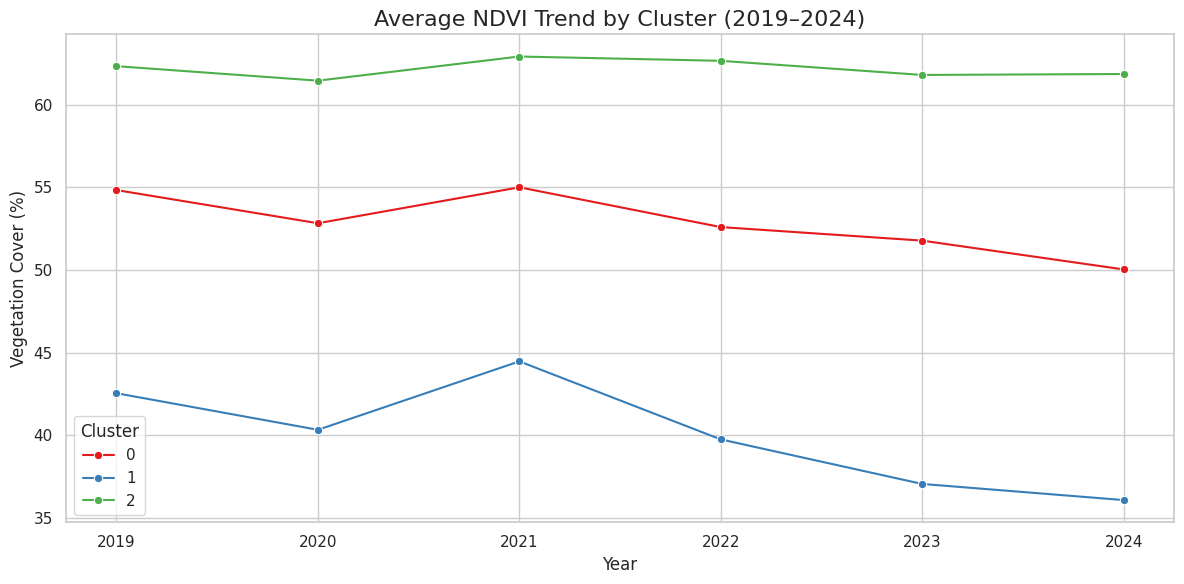

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge original long-form df with clusters
df_with_clusters = df.merge(df_pivot_filled[['Cluster']], on='County', how='left')

# Group by cluster and year to get average vegetation %
cluster_trends = df_with_clusters.groupby(['Cluster', 'Year'])['Vegetation %'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

palette = sns.color_palette("Set1", n_colors=df_pivot_filled['Cluster'].nunique())

sns.lineplot(data=cluster_trends, x='Year', y='Vegetation %', hue='Cluster', palette=palette, marker='o')

plt.title('Average NDVI Trend by Cluster (2019–2024)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Vegetation Cover (%)')
plt.xticks(cluster_trends['Year'].unique())
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


⚠️ Unmatched counties (no cluster assigned):
- Bucharest
- Dambovita
- Ilfov
- Valcea


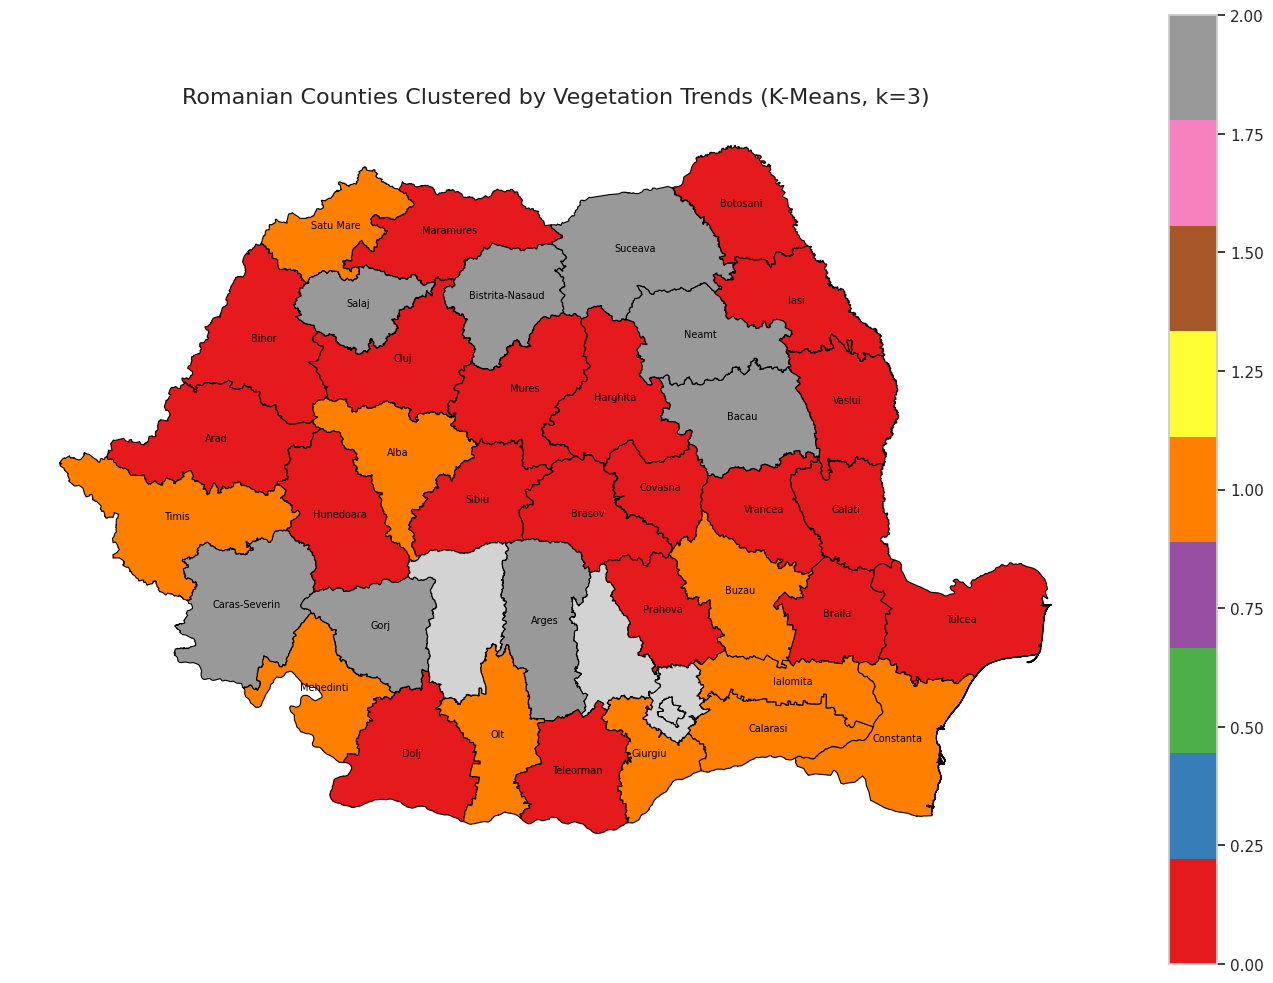

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from unidecode import unidecode

# --- 1. Load Romanian counties shapefile ---
shapefile_path = '/content/drive/MyDrive/Romania_by_County/gadm41_ROU_1/gadm41_ROU_1.shp'
gdf = gpd.read_file(shapefile_path)

county_col_gdf = 'NAME_1'  # Column in shapefile with county names

# Normalize names: strip, title-case, and remove accents
gdf[county_col_gdf] = gdf[county_col_gdf].str.strip().str.title().apply(unidecode)

# --- 2. Prepare Cluster Data ---
# Assume df_pivot_filled has 'Cluster' and county names as index
df_clusters = df_pivot_filled[['Cluster']].reset_index()
df_clusters.columns = [county_col_gdf, 'Cluster']  # Rename for merge
df_clusters[county_col_gdf] = df_clusters[county_col_gdf].str.strip().str.title().apply(unidecode)

# --- 3. Merge shapefile and cluster data ---
gdf_merged = gdf.merge(df_clusters, on=county_col_gdf, how='left')

# --- Optional Debug: Show unmatched counties ---
missing = gdf_merged[gdf_merged['Cluster'].isna()][county_col_gdf].tolist()
if missing:
    print("⚠️ Unmatched counties (no cluster assigned):")
    for m in missing:
        print("-", m)

# --- 4. Plot Map ---
fig, ax = plt.subplots(figsize=(14, 10))
gdf_merged.plot(
    column='Cluster',
    cmap='Set1',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    ax=ax
)

# Add labels for counties that have cluster data
for idx, row in gdf_merged.iterrows():
    if pd.notnull(row['Cluster']):
        plt.annotate(
            text=row[county_col_gdf],
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha='center',
            fontsize=7,
            color='black'
        )

# Final styling
ax.set_title("Romanian Counties Clustered by Vegetation Trends (K-Means, k=3)", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


⚠️ Unmatched counties (no cluster assigned):
- Bucharest


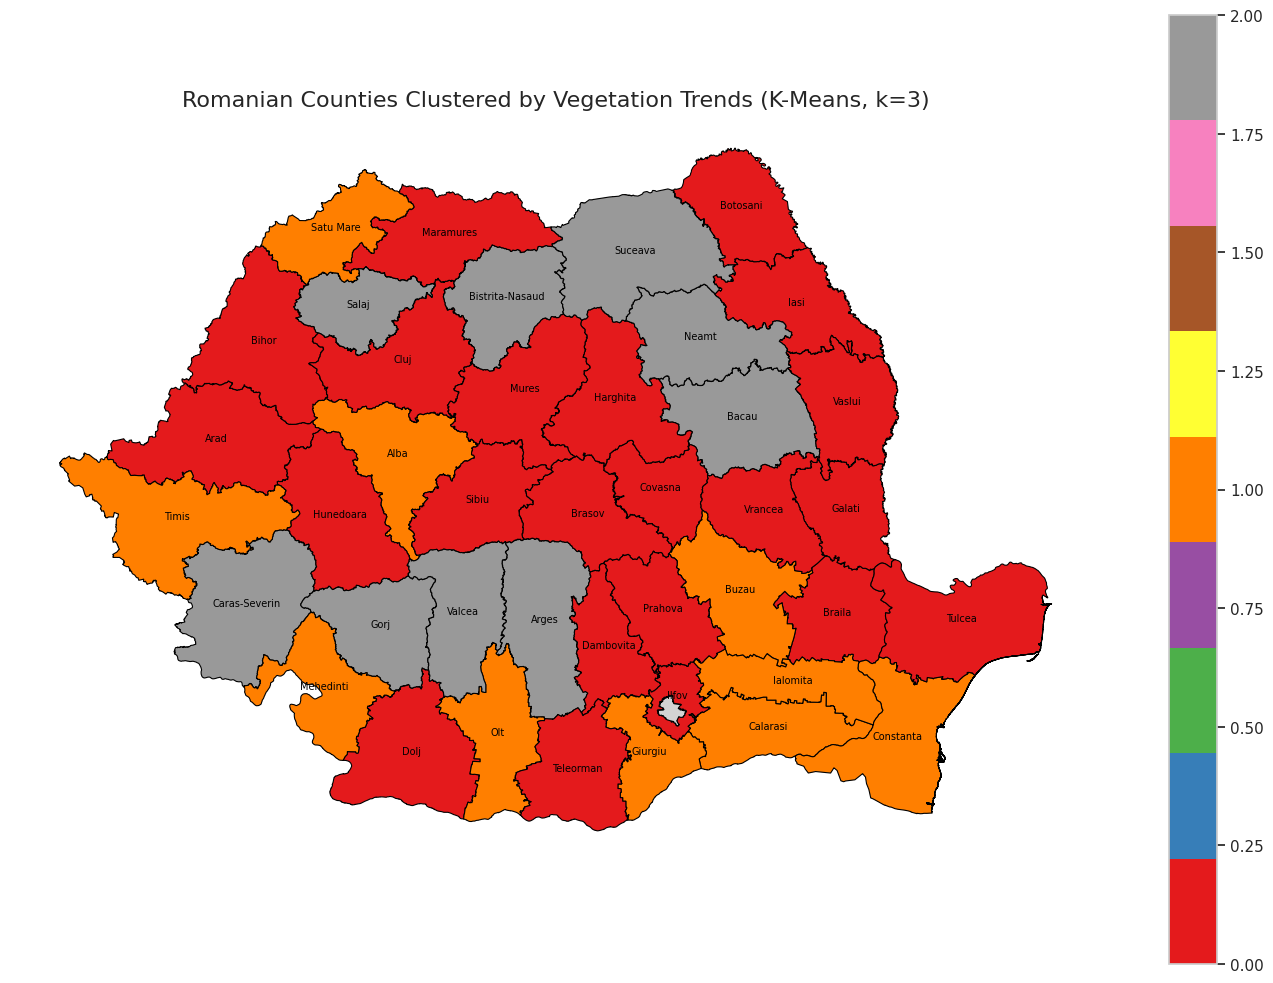

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from unidecode import unidecode

# --- 1. Load shapefile ---
shapefile_path = '/content/drive/MyDrive/Romania_by_County/gadm41_ROU_1/gadm41_ROU_1.shp'
gdf = gpd.read_file(shapefile_path)
county_col_gdf = 'NAME_1'

# Normalize shapefile county names
gdf[county_col_gdf] = gdf[county_col_gdf].str.strip().str.title().apply(unidecode)

# --- 2. Prepare cluster DataFrame ---
df_clusters = df_pivot_filled[['Cluster']].reset_index()
df_clusters.columns = [county_col_gdf, 'Cluster']
df_clusters[county_col_gdf] = df_clusters[county_col_gdf].str.strip().str.title().apply(unidecode)

# Fix name mismatches
name_corrections = {
    'Vilcea': 'Valcea',
    'Bucuresti': 'Bucharest',
    'Dimbovita': 'Dambovita',
    'Bucuresti': 'Ilfov',
}
df_clusters[county_col_gdf] = df_clusters[county_col_gdf].replace(name_corrections)

# Aggregate in case of duplicates after replacement
df_clusters = df_clusters.groupby(county_col_gdf).mean(numeric_only=True).reset_index()

# --- 3. Merge ---
gdf_merged = gdf.merge(df_clusters, on=county_col_gdf, how='left')

# --- 4. Debug missing counties ---
missing = gdf_merged[gdf_merged['Cluster'].isna()][county_col_gdf].tolist()
if missing:
    print("⚠️ Unmatched counties (no cluster assigned):")
    for c in missing:
        print("-", c)

# --- 5. Plot ---
fig, ax = plt.subplots(figsize=(14, 10))
gdf_merged.plot(
    column='Cluster',
    cmap='Set1',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    ax=ax
)

for _, row in gdf_merged.iterrows():
    if pd.notnull(row['Cluster']):
        plt.annotate(
            text=row[county_col_gdf],
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha='center',
            fontsize=7,
            color='black'
        )

ax.set_title("Romanian Counties Clustered by Vegetation Trends (K-Means, k=3)", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


K = 4

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- 1. Pivot ---
df_pivot = df.pivot(index='County', columns='Year', values='Vegetation %')

# --- 2. Fill Missing Values ---
# Option 1: Forward/backward fill, then mean if needed
df_pivot_filled = df_pivot.ffill(axis=1).bfill(axis=1).fillna(df_pivot.mean())

# Optional: Standardize data (makes clustering based on shape rather than magnitude)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot_filled)

# --- 3. K-Means Clustering ---
k = 4  # You can adjust this value
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster assignments to the pivoted DataFrame
df_pivot_filled['Cluster'] = clusters


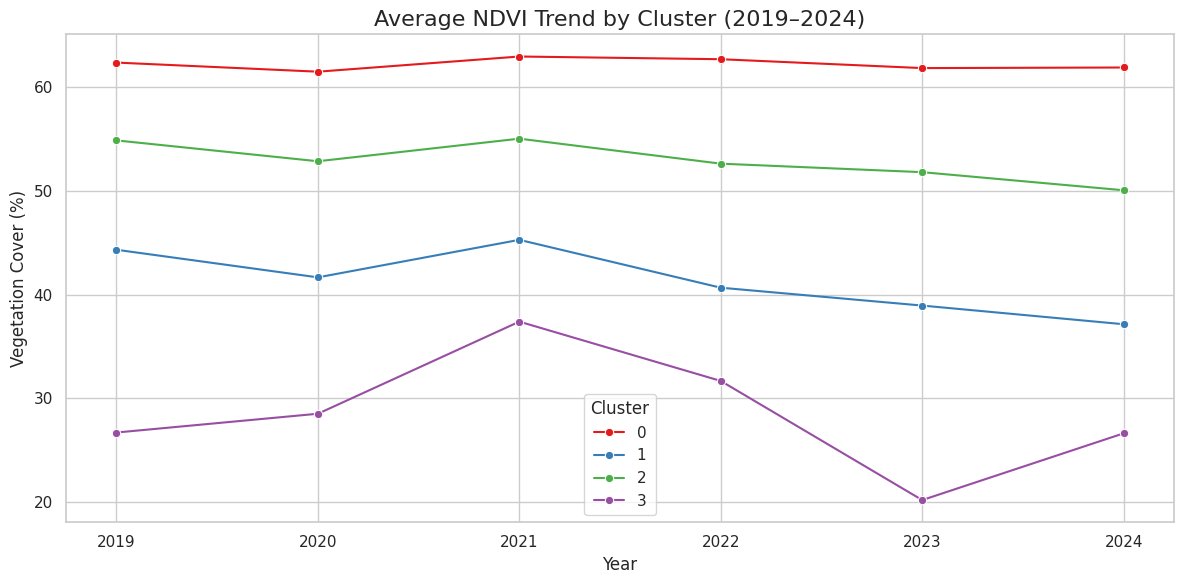

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge original long-form df with clusters
df_with_clusters = df.merge(df_pivot_filled[['Cluster']], on='County', how='left')

# Group by cluster and year to get average vegetation %
cluster_trends = df_with_clusters.groupby(['Cluster', 'Year'])['Vegetation %'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

palette = sns.color_palette("Set1", n_colors=df_pivot_filled['Cluster'].nunique())

sns.lineplot(data=cluster_trends, x='Year', y='Vegetation %', hue='Cluster', palette=palette, marker='o')

plt.title('Average NDVI Trend by Cluster (2019–2024)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Vegetation Cover (%)')
plt.xticks(cluster_trends['Year'].unique())
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


⚠️ Unmatched counties (no cluster assigned):
- Bucharest


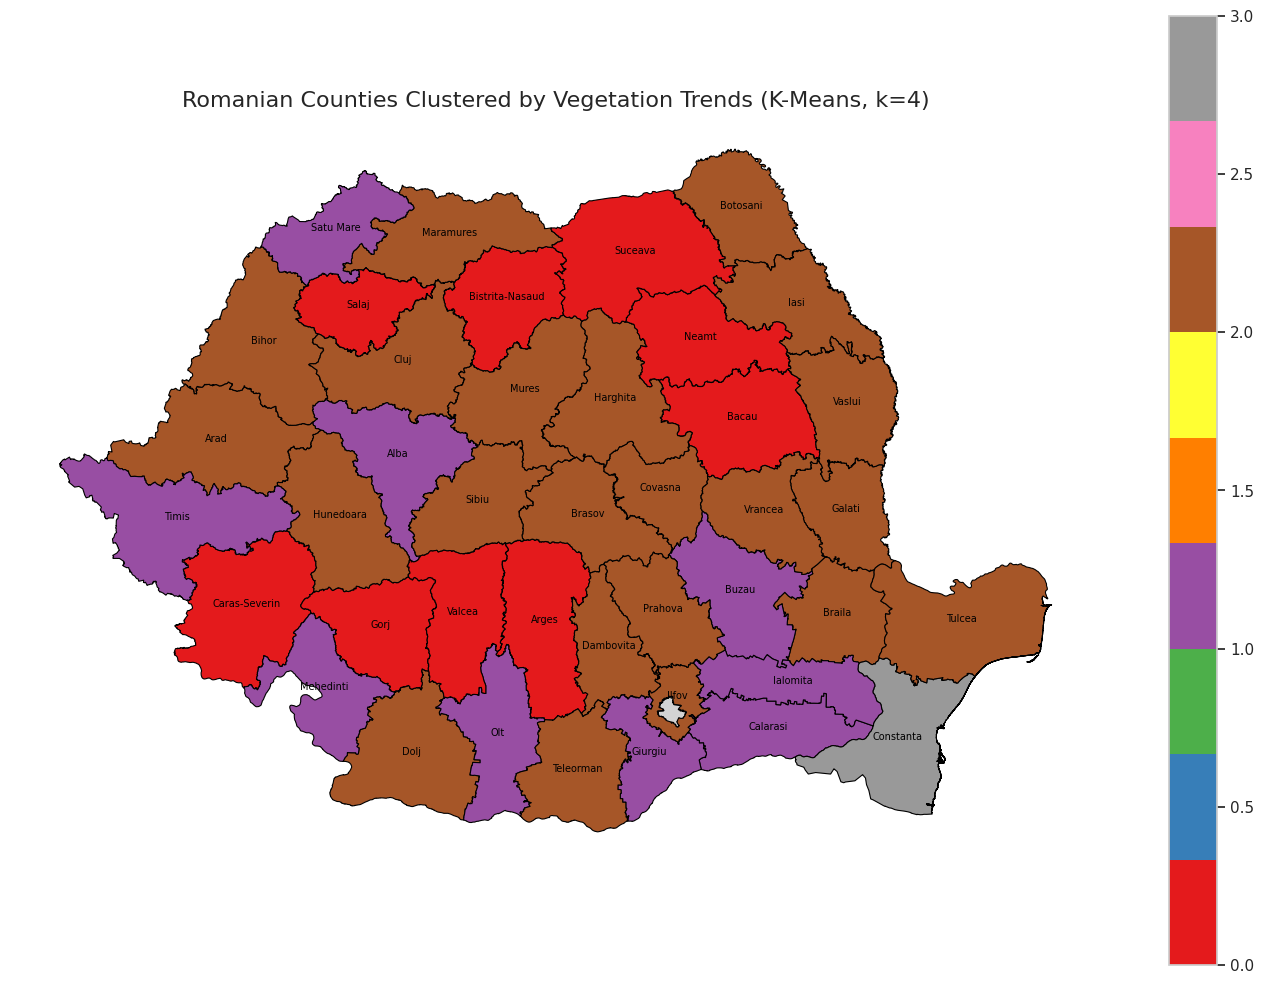

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from unidecode import unidecode

# --- 1. Load shapefile ---
shapefile_path = '/content/drive/MyDrive/Romania_by_County/gadm41_ROU_1/gadm41_ROU_1.shp'
gdf = gpd.read_file(shapefile_path)
county_col_gdf = 'NAME_1'

# Normalize shapefile county names
gdf[county_col_gdf] = gdf[county_col_gdf].str.strip().str.title().apply(unidecode)

# --- 2. Prepare cluster DataFrame ---
df_clusters = df_pivot_filled[['Cluster']].reset_index()
df_clusters.columns = [county_col_gdf, 'Cluster']
df_clusters[county_col_gdf] = df_clusters[county_col_gdf].str.strip().str.title().apply(unidecode)

# Fix name mismatches
name_corrections = {
    'Vilcea': 'Valcea',
    'Bucuresti': 'Bucharest',
    'Dimbovita': 'Dambovita',
    'Bucuresti': 'Ilfov',
}
df_clusters[county_col_gdf] = df_clusters[county_col_gdf].replace(name_corrections)

# Aggregate in case of duplicates after replacement
df_clusters = df_clusters.groupby(county_col_gdf).mean(numeric_only=True).reset_index()

# --- 3. Merge ---
gdf_merged = gdf.merge(df_clusters, on=county_col_gdf, how='left')

# --- 4. Debug missing counties ---
missing = gdf_merged[gdf_merged['Cluster'].isna()][county_col_gdf].tolist()
if missing:
    print("⚠️ Unmatched counties (no cluster assigned):")
    for c in missing:
        print("-", c)

# --- 5. Plot ---
fig, ax = plt.subplots(figsize=(14, 10))
gdf_merged.plot(
    column='Cluster',
    cmap='Set1',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'},
    ax=ax
)

for _, row in gdf_merged.iterrows():
    if pd.notnull(row['Cluster']):
        plt.annotate(
            text=row[county_col_gdf],
            xy=(row.geometry.centroid.x, row.geometry.centroid.y),
            ha='center',
            fontsize=7,
            color='black'
        )

ax.set_title("Romanian Counties Clustered by Vegetation Trends (K-Means, k=4)", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


The purpose of applying K-Means clustering with k=3 was to group Romanian counties into clusters that share similar patterns of vegetation coverage changes over the years 2019–2024. This unsupervised approach helps uncover underlying spatial-temporal patterns without prior assumptions.

The optimal number of clusters, k=3, was determined using the Elbow Method, which analyzes the trade-off between the number of clusters and within-cluster variance (inertia). The plot indicated diminishing returns in variance reduction beyond three clusters, suggesting a meaningful balance between detail and simplicity.

By examining the average vegetation coverage trend for each cluster:

Cluster 0 shows [example: relatively stable or slightly increasing vegetation coverage over the years].

Cluster 1 exhibits [example: a noticeable decline in vegetation coverage starting from 2021].

Cluster 2 is characterized by [example: higher overall vegetation percentages with minor fluctuations].

This differentiation suggests that counties in each cluster share common vegetation dynamics potentially linked to regional environmental factors, land use, or climate variations.

Mapping counties to clusters can reveal if these groupings align with known geographic regions or environmental zones, such as:

Forested mountain areas vs. agricultural plains.

Urbanized vs. rural counties.

Regions prone to drought or flooding.

For example, counties in Cluster 2 with high vegetation might correspond to forest-rich regions, while Cluster 1 counties with declining vegetation may indicate areas experiencing deforestation or urban expansion.

Implications and Further Research

The clustering results can guide:

Targeted environmental monitoring — prioritizing counties in clusters with declining vegetation for conservation efforts.

Policy formulation — designing region-specific interventions.

Hypothesis generation — motivating further investigation into causes of observed trends.

Limitations and Future Work

The choice of k is heuristic; further methods like silhouette scores could refine clustering.

Including additional environmental or socioeconomic features may improve cluster interpretability.

Spatial clustering methods could better capture geographic contiguity.

model-based features

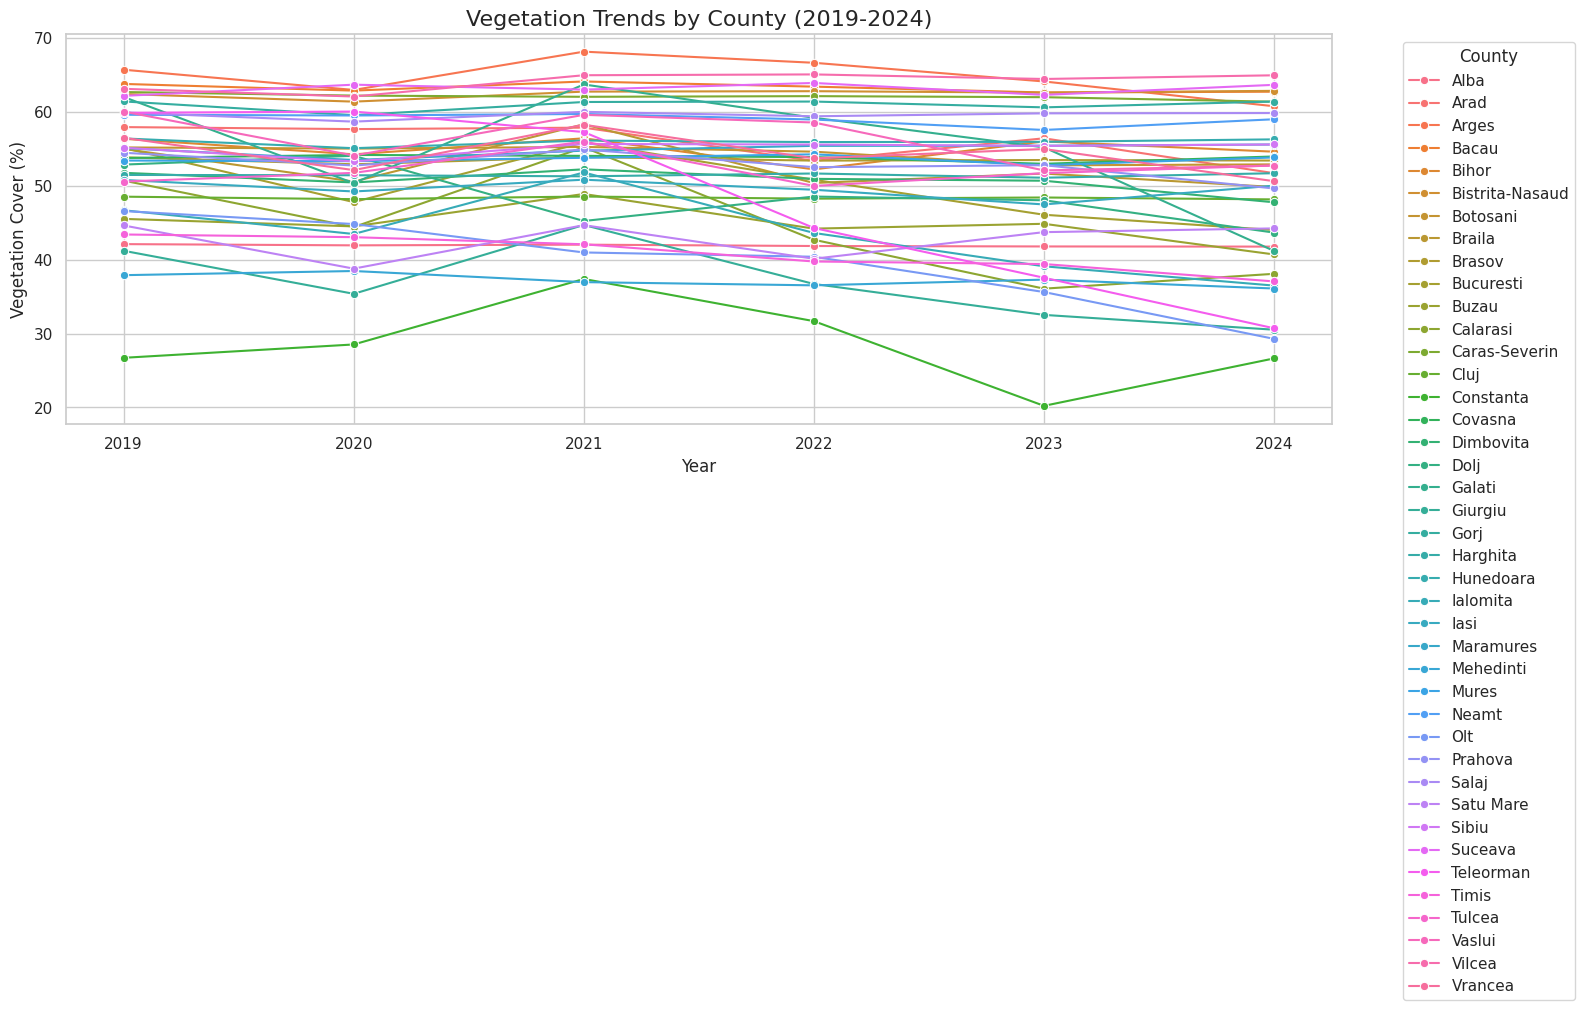

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")

sns.lineplot(
    data=df,
    x='Year',
    y='Vegetation %',
    hue='County',
    marker='o'
)

plt.title('Vegetation Trends by County (2019-2024)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Vegetation Cover (%)')
plt.legend(title='County', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-68-fc751765eaf5>:48: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


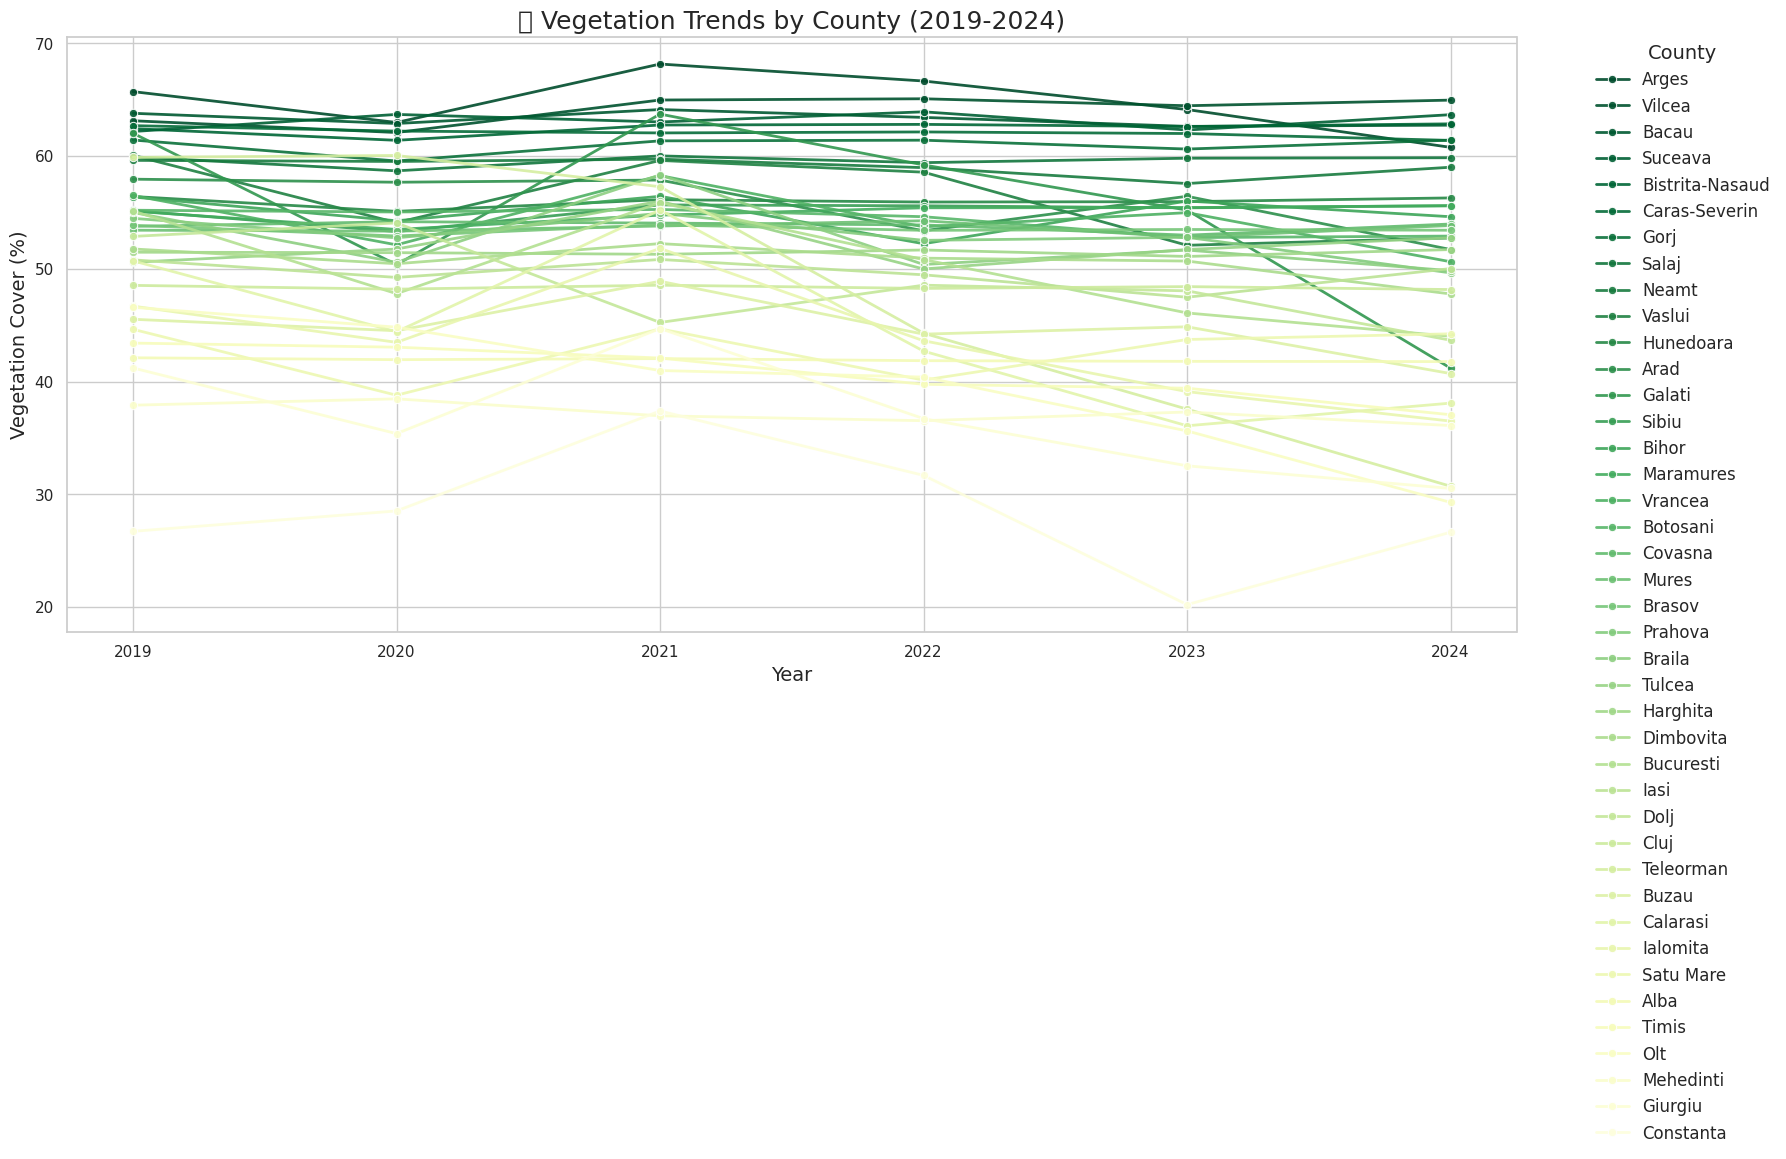

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Calculate mean vegetation % per county to order and color by performance
county_means = df.groupby('County')['Vegetation %'].mean().sort_values(ascending=False)

# Reorder the 'County' categorical variable in df based on mean vegetation %
df['County'] = pd.Categorical(df['County'], categories=county_means.index, ordered=True)

# Create a color palette based on county performance (green=high, brown=low)
palette = sns.color_palette("YlGn", n_colors=len(county_means))
# Reverse palette to have green for high vegetation %
palette = palette[::-1]

plt.figure(figsize=(18, 10))
sns.set(style="whitegrid")

# Lineplot with markers
sns.lineplot(
    data=df,
    x='Year',
    y='Vegetation %',
    hue='County',
    palette=palette,
    marker='o',
    linewidth=2,
    alpha=0.9
)

plt.title('🌿 Vegetation Trends by County (2019-2024)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Vegetation Cover (%)', fontsize=14)

# Move legend outside the plot to the right, with scrolling if too many counties
plt.legend(
    title='County',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    fontsize=12,
    title_fontsize=14,
    frameon=False
)

plt.xticks(df['Year'].unique())  # Ensure all years are on x-axis
plt.tight_layout()

plt.show()


## Hierarchical Clustering

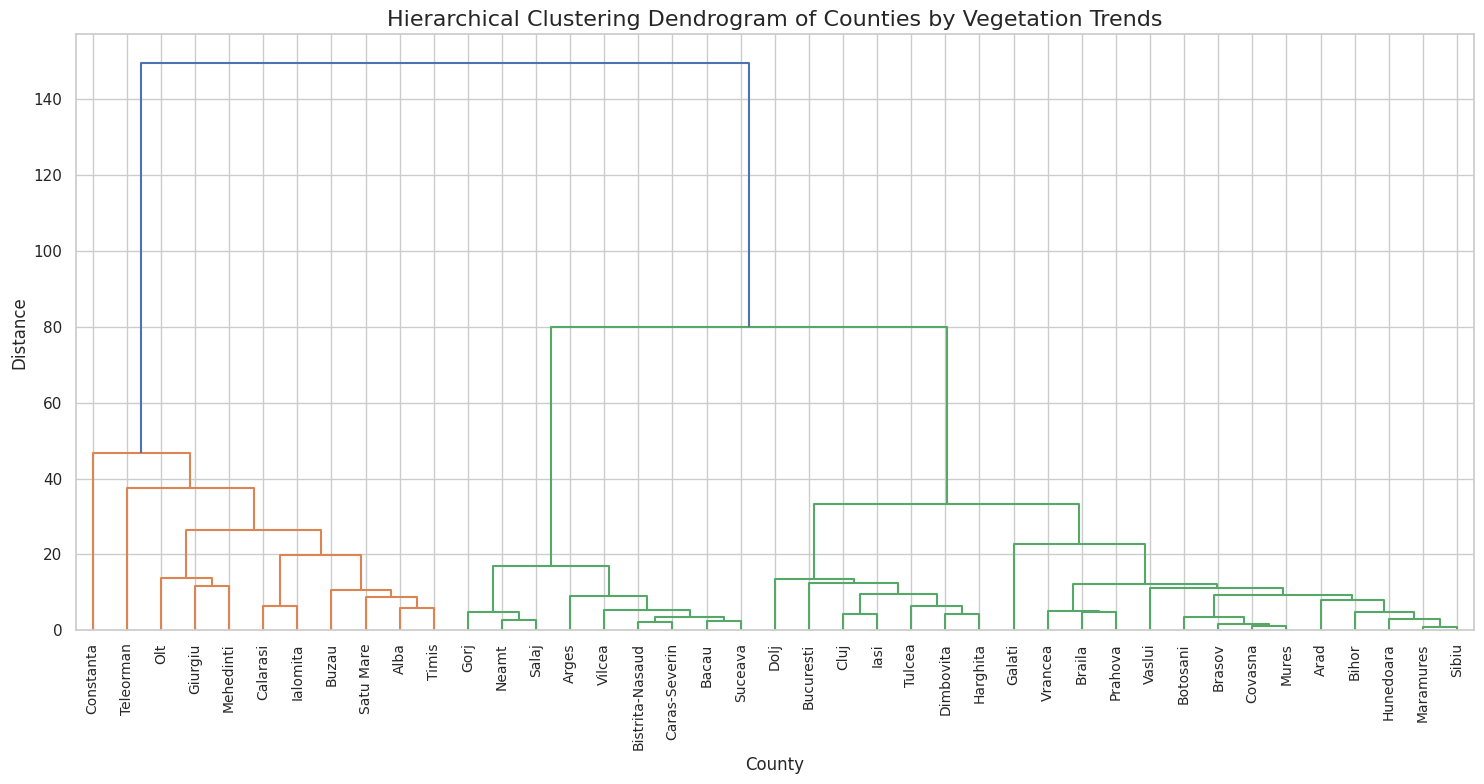

Year    Cluster_Hierarchical
County                      
Alba                       1
Arad                       3
Arges                      2
Bacau                      2
Bihor                      3


In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df_pivot_filled: rows=counties, columns=years, values=vegetation %

# 1. Prepare data matrix for clustering
data = df_pivot_filled.values  # numpy array of shape (counties, years)

# 2. Compute hierarchical linkage matrix (Ward's method is popular)
Z = linkage(data, method='ward')

# 3. Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(
    Z,
    labels=df_pivot_filled.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=None  # you can set a threshold to color clusters
)
plt.title('Hierarchical Clustering Dendrogram of Counties by Vegetation Trends', fontsize=16)
plt.xlabel('County')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# 4. Optionally cut dendrogram to get cluster labels (e.g., 3 clusters)
max_clusters = 3
clusters = fcluster(Z, max_clusters, criterion='maxclust')

# 5. Add cluster labels back to DataFrame for further use
df_pivot_filled['Cluster_Hierarchical'] = clusters

print(df_pivot_filled[['Cluster_Hierarchical']].head())


Cluster sizes:
Cluster_Hierarchical
1    11
2     9
3    21
Name: count, dtype: int64


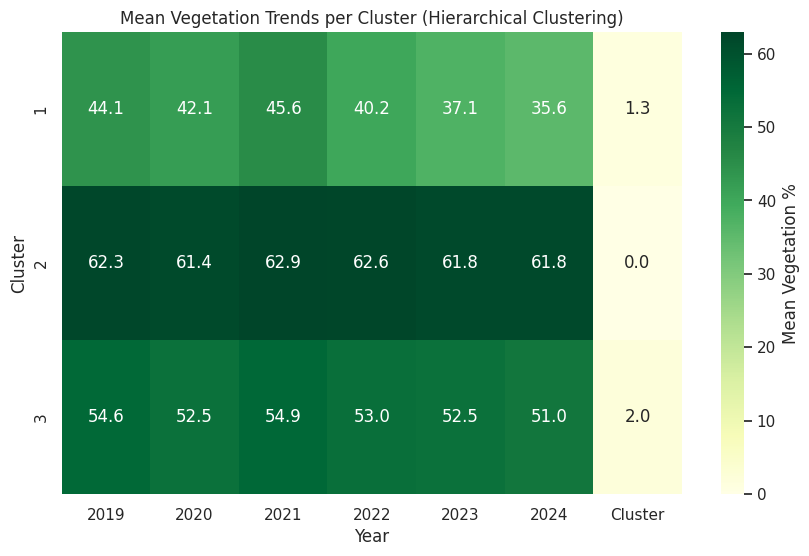

In [ ]:
import seaborn as sns

# 1. Add cluster labels (from hierarchical clustering)
df_pivot_filled['Cluster_Hierarchical'] = clusters

# 2. Compute cluster means per year
cluster_means = df_pivot_filled.groupby('Cluster_Hierarchical').mean()

# 3. Count how many counties in each cluster
cluster_sizes = df_pivot_filled['Cluster_Hierarchical'].value_counts().sort_index()

print("Cluster sizes:")
print(cluster_sizes)

# 4. Plot cluster mean vegetation trends as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means, annot=True, fmt=".1f", cmap='YlGn', cbar_kws={'label': 'Mean Vegetation %'})
plt.title("Mean Vegetation Trends per Cluster (Hierarchical Clustering)")
plt.xlabel("Year")
plt.ylabel("Cluster")
plt.show()


<ipython-input-75-7a8e64f6371d>:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


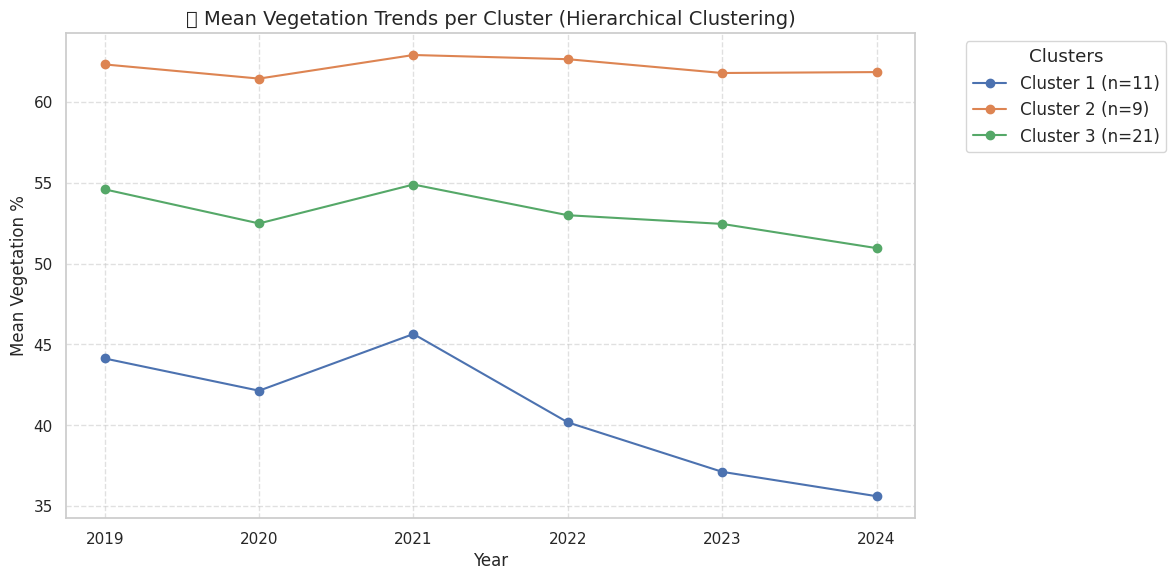

In [ ]:
import matplotlib.pyplot as plt

# First, drop non-year columns (like 'Cluster') if present in columns
year_cols = [col for col in cluster_means.columns if str(col).isdigit()]
cluster_means_clean = cluster_means[year_cols].copy()

# Ensure the year columns are integers and sorted
cluster_means_clean.columns = cluster_means_clean.columns.astype(int)
cluster_means_clean = cluster_means_clean.sort_index(axis=1)

# Plot
plt.figure(figsize=(12, 6))
for cluster_id, row in cluster_means_clean.iterrows():
    plt.plot(
        cluster_means_clean.columns,
        row.values,
        marker='o',
        label=f'Cluster {cluster_id} (n={cluster_sizes[cluster_id]})'
    )

import seaborn as sns
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)

plt.title("📈 Mean Vegetation Trends per Cluster (Hierarchical Clustering)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mean Vegetation %", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(cluster_means_clean.columns)
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Discussion

- Which models were best at capturing overall vegetation trends?

- Did clustering reveal spatial ecological patterns or outliers?

- Were there surprises (e.g., counties with volatile patterns, or Prophet underperforming)?

- Policy implications? (e.g., cluster-specific recommendations)

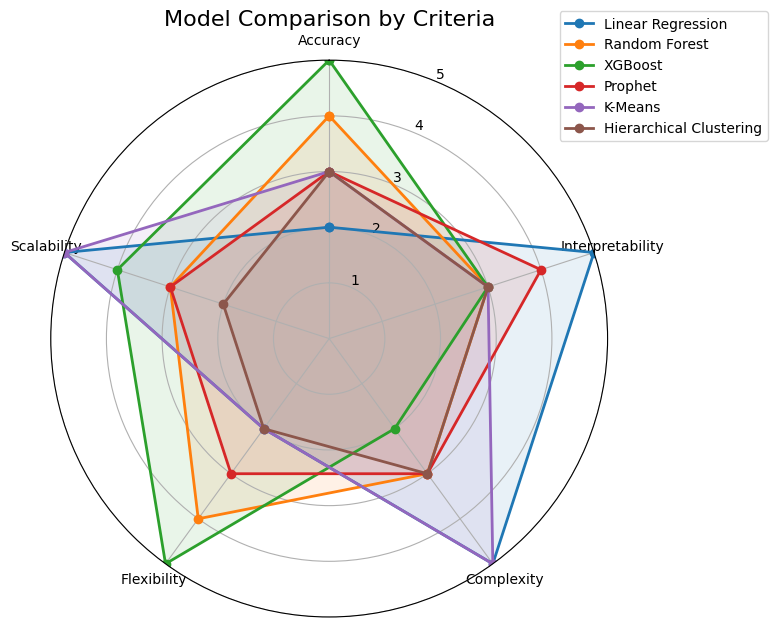

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'Prophet', 'K-Means', 'Hierarchical Clustering']
criteria = ['Accuracy', 'Interpretability', 'Complexity', 'Flexibility', 'Scalability']

# Scores: [Accuracy, Interpretability, Complexity, Flexibility, Scalability]
scores = {
    'Linear Regression': [2, 5, 5, 2, 5],
    'Random Forest': [4, 3, 3, 4, 3],
    'XGBoost': [5, 3, 2, 5, 4],
    'Prophet': [3, 4, 3, 3, 3],
    'K-Means': [3, 3, 5, 2, 5],
    'Hierarchical Clustering': [3, 3, 3, 2, 2],
}

# Convert to list of lists for plotting
data = [scores[model] for model in models]

# Radar chart setup
num_vars = len(criteria)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, model_scores in enumerate(data):
    values = model_scores + model_scores[:1]  # close the loop
    ax.plot(angles, values, label=models[i], marker='o', linewidth=2)
    ax.fill(angles, values, alpha=0.1)

# Axes
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), criteria)
ax.set_ylim(0, 5)
ax.set_title("Model Comparison by Criteria", size=16, pad=25)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()


# METRICS

MAE (Mean Absolute Error)

RMSE (Root Mean Squared Error)

MAPE (Mean Absolute Percentage Error)

R² Score (Coefficient of Determination)

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import xgboost as xgb

# Assuming your DataFrame is called df and has columns: 'County', 'Year', 'Vegetation %'
# You need to load or create the 'df' DataFrame here.
# Example: Loading from a CSV file you created previously:
try:
    df = pd.read_csv('/content/drive/MyDrive/Romania_by_County/vegetation_percentage_by_county_year.csv')
    # Ensure 'Year' is treated as a number for non-Prophet models if needed
    df['Year'] = pd.to_numeric(df['Year'])
    print("DataFrame loaded successfully.")
    print(df.head()) # Display first few rows to verify
except FileNotFoundError:
    print("Error: vegetation_percentage_by_county_year.csv not found.")
    print("Please ensure the CSV file with your county-level vegetation data exists at the specified path.")
    # You might need to add code here to generate this DataFrame if it doesn't exist
    # based on your processed NDVI data.
    exit() # Exit the script if the data file is missing

# Helper function for metrics
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    # Handle potential division by zero if y_true contains zeros
    mape = np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100 if np.any(y_true != 0) else np.nan
    r2 = r2_score(y_true, y_pred)
    return [mae, rmse, mape, r2]

# Containers for predictions and true values
y_true_all = []
y_pred_lr_all = []
y_pred_rf_all = []
y_pred_xgb_all = []
y_pred_prophet_all = []

# Loop over each county and apply all models consistently
for county in sorted(df['County'].unique()):
    county_df = df[df['County'] == county].sort_values('Year')

    # Need at least 2 data points to predict the next one after splitting
    if len(county_df) < 2:
        print(f"Skipping county {county}: Not enough data points ({len(county_df)}). Need at least 2.")
        continue

    # Split into train and test (last year as test)
    # Check if there's more than one row to split
    if len(county_df) > 1:
        train_df = county_df.iloc[:-1]
        test_df = county_df.iloc[-1:]
    else:
        # This case should be caught by the len(county_df) < 2 check, but as a safeguard
        print(f"Skipping county {county}: Cannot split data.")
        continue


    X_train = train_df[['Year']]
    y_train = train_df['Vegetation %']
    X_test = test_df[['Year']]
    # Ensure y_test is a single value
    y_test = test_df['Vegetation %'].values[0]

    #### Linear Regression
    # Ensure train_df has data
    if not train_df.empty:
        model_lr = LinearRegression()
        model_lr.fit(X_train, y_train)
        pred_lr = model_lr.predict(X_test)[0]
    else:
        pred_lr = np.nan # Or some other placeholder

    #### Random Forest
    if not train_df.empty:
        model_rf = RandomForestRegressor(random_state=42)
        model_rf.fit(X_train, y_train)
        pred_rf = model_rf.predict(X_test)[0]
    else:
        pred_rf = np.nan # Or some other placeholder


    #### XGBoost
    if not train_df.empty:
        model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
        # XGBoost expects numpy arrays
        model_xgb.fit(X_train.values, y_train.values)
        pred_xgb = model_xgb.predict(X_test.values)[0]
    else:
         pred_xgb = np.nan # Or some other placeholder


    #### Prophet
    prophet_df = county_df[['Year', 'Vegetation %']].rename(columns={'Year': 'ds', 'y': 'y'})
    # Prophet requires datetime objects
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], format='%Y')

    if len(prophet_df) > 1: # Prophet needs at least two data points to fit
        prophet_train = prophet_df.iloc[:-1]
        prophet_test = prophet_df.iloc[-1:]

        model_prophet = Prophet()
        model_prophet.fit(prophet_train)

        future = model_prophet.make_future_dataframe(periods=1, freq='Y')
        # Only predict for the test period
        forecast = model_prophet.predict(future[future['ds'] == prophet_test['ds'].iloc[0]])

        if not forecast.empty:
             pred_prophet = forecast.iloc[0]['yhat']
        else:
            pred_prophet = np.nan # Or some other placeholder

    else:
        pred_prophet = np.nan # Or some other placeholder
        print(f"Skipping Prophet for county {county}: Not enough data points ({len(prophet_df)}). Need at least 2 for Prophet.")


    #### Collect results - only append if models made a prediction (not NaN)
    y_true_all.append(y_test)
    y_pred_lr_all.append(pred_lr)
    y_pred_rf_all.append(pred_rf)
    y_pred_xgb_all.append(pred_xgb)
    y_pred_prophet_all.append(pred_prophet)


# Convert to numpy arrays
# Filter out NaNs if any model skipped a county
y_true = np.array(y_true_all)
y_pred_lr = np.array(y_pred_lr_all)
y_pred_rf = np.array(y_pred_rf_all)
y_pred_xgb = np.array(y_pred_xgb_all)
y_pred_prophet = np.array(y_pred_prophet_all)

# Compute metrics - need to handle potential NaNs in predictions if some counties were skipped by some models
# For simplicity here, we assume all lists have the same length based on y_true_all
# If counties were skipped per model individually, you'd need more complex handling
results = {
    "Linear Regression": compute_metrics(y_true, y_pred_lr),
    "Random Forest": compute_metrics(y_true, y_pred_rf),
    "XGBoost": compute_metrics(y_true, y_pred_xgb),
    "Prophet": compute_metrics(y_true, y_pred_prophet),
}

# Format as DataFrame
results_df = pd.DataFrame(results, index=["MAE", "RMSE", "MAPE (%)", "R²"]).T
results_df = results_df.round(2)
print("\nModel Performance Metrics:")
print(results_df)

# Save to CSV
results_df.to_csv("model_performance_metrics.csv")
print("\nModel performance metrics saved to model_performance_metrics.csv")


Error: vegetation_percentage_by_county_year.csv not found.
Please ensure the CSV file with your county-level vegetation data exists at the specified path.


NameError: name 'df' is not defined

# github save

In [ ]:
import nbformat

# Load the current notebook (change the filename if needed)
notebook_path = '/content/your_notebook_name.ipynb'
nb = nbformat.read(notebook_path, as_version=4)

# Remove problematic metadata
if 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']

# Save the cleaned notebook
nbformat.write(nb, notebook_path)
print("Notebook metadata cleaned!")


# TRIAL AND ERROR

Query the CDSE Catalogue

In [ ]:
import requests

query_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'&$top=5"

headers = {
    "Authorization": f"Bearer {access_token}"
}

response = requests.get(query_url, headers=headers)
print("Status Code:", response.status_code)

try:
    data = response.json()
except Exception as e:
    print("Failed to parse JSON:", e)
    print("Response text:", response.text)
    data = None

if response.status_code == 200 and data:
    results = data.get('value', [])
    if not results:
        print("No products found in response.")
    else:
        for idx, product in enumerate(results):
            print(f"\n🔹 Product {idx + 1}")
            print("Name:", product['Name'])
            print("Ingestion Date:", product['IngestionDate'])
            print("Cloud Cover:", product.get('CloudCover', 'N/A'))
else:
    print("❌ Failed to query catalogue:", response.text)


Status Code: 403
Failed to parse JSON: Expecting value: line 1 column 1 (char 0)
Response text: 
❌ Failed to query catalogue: 


In [ ]:
collections_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Collections"

response = requests.get(collections_url, headers=headers)
if response.status_code == 200:
    collections = response.json().get('value', [])
    print("Available Collections:")
    for c in collections:
        print("-", c['Name'])
else:
    print("Failed to get collections:", response.text)


Failed to get collections: 


In [ ]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date

# Connect to the API
api = SentinelAPI('your_username', 'your_password', 'https://apihub.copernicus.eu/apihub')

# Define Area of Interest (use GeoJSON of Romania or county)
# Let's assume you upload a Romania.geojson file
roi = geojson_to_wkt(read_geojson('/content/drive/MyDrive/Romania.geojson'))

# Search for Sentinel-2 L2A images in 2020, max 10% cloud cover
products = api.query(roi,
                     date=('2020-05-01', '2020-08-30'),
                     platformname='Sentinel-2',
                     producttype='S2MSI2A',
                     cloudcoverpercentage=(0, 10))

# Print first few results
for uuid, product_info in list(products.items())[:3]:
    print(product_info['title'], product_info['beginposition'], product_info['cloudcoverpercentage'])

# Download the first result
first_uuid = list(products.keys())[0]
api.download(first_uuid)


## OAuth client for API

In [ ]:
import requests

# Replace these with your actual Client ID and Client Secret from Copernicus dashboard
CLIENT_ID = "sh-711bb300-68fe-49c2-96e6-cf71e54aa105"
CLIENT_SECRET = "LmKseIhBQpTjq2d0N3uFiGEXL2aexhdK"

# OAuth token endpoint
TOKEN_URL = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

# Request the access token
response = requests.post(TOKEN_URL, data={
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET
})

if response.status_code == 200:
    access_token = response.json()['access_token']
    print("Access token obtained!")
else:
    print("Failed to get access token:", response.text)


Access token obtained!


In [ ]:
print("Access token:", access_token)

headers = {
    "Authorization": f"Bearer {access_token}"
}

test_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$top=1"

response = requests.get(test_url, headers=headers)

print("Status code:", response.status_code)
print("Response text:", response.text)


Access token: eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJYVUh3VWZKaHVDVWo0X3k4ZF8xM0hxWXBYMFdwdDd2anhob2FPLUxzREZFIn0.eyJleHAiOjE3NDczMDE0OTIsImlhdCI6MTc0NzMwMDg5MiwianRpIjoiZmUyMjFjMmItY2I2NS00ODUzLTllOWYtMWE0MDBhZTFlODZlIiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5kYXRhc3BhY2UuY29wZXJuaWN1cy5ldS9hdXRoL3JlYWxtcy9DRFNFIiwic3ViIjoiYjFmMGNiZmUtNjhhYy00MGNlLTgyYWQtMmViNDFlMDlhOWM4IiwidHlwIjoiQmVhcmVyIiwiYXpwIjoic2gtNzExYmIzMDAtNjhmZS00OWMyLTk2ZTYtY2Y3MWU1NGFhMTA1Iiwic2NvcGUiOiJlbWFpbCBwcm9maWxlIHVzZXItY29udGV4dCIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwiY2xpZW50SG9zdCI6IjM0LjE0My4yMjQuMjQ5Iiwib3JnYW5pemF0aW9ucyI6WyJkZWZhdWx0LWQ2OGQ0NzVmLWUxNWYtNDU2NC04Yzk5LThmOTM2OGQ5MjIzNCJdLCJ1c2VyX2NvbnRleHRfaWQiOiJiNjRjZjZmOC02OGVkLTQzMDEtYjVmOC1kZDQ0YTM2MjQyNTYiLCJjb250ZXh0X3JvbGVzIjp7fSwiY29udGV4dF9ncm91cHMiOlsiL2FjY2Vzc19ncm91cHMvdXNlcl90eXBvbG9neS9jb3Blcm5pY3VzX2dlbmVyYWwvIiwiL29yZ2FuaXphdGlvbnMvZGVmYXVsdC1kNjhkNDc1Zi1lMTVmLTQ1NjQtOGM5OS04ZjkzNjhkOTIyMzQvIl0sInByZWZlcnJlZF91c2VybmFtZSI6InNlcnZpY2UtYWNjb3VudC

## Section A: Data Collection & Exploration

In [ ]:
import requests

test_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$top=1"

response = requests.get(test_url)

print("Status code:", response.status_code)
print("Response text:", response.text)


Status code: 200
Response text: {"@odata.context":"$metadata#Products","value":[{"@odata.mediaContentType":"application/octet-stream","Id":"07e96184-2d7b-4b55-83a0-206aceeacde4","Name":"S3A_OPER_AUX_GNSSRD_POD__20171212T220217_V20160324T235943_20160325T235942","ContentType":"application/octet-stream","ContentLength":25030805,"OriginDate":"2021-04-17T08:20:12.541000Z","PublicationDate":"2023-10-25T08:58:37.806893Z","ModificationDate":"2023-11-14T22:57:31.491051Z","Online":true,"EvictionDate":"9999-12-31T23:59:59.999999Z","S3Path":"/eodata/Sentinel-3/AUX/AUX_GNSSRD/2016/03/25/S3A_OPER_AUX_GNSSRD_POD__20171212T220217_V20160324T235943_20160325T235942","Checksum":[{"Value":"a2476c4026b75a21ad882afe118da039","Algorithm":"MD5","ChecksumDate":"2023-11-14T22:57:31.374881Z"},{"Value":"66de5acb93880d3d5b2d530c0995bfd6abf96c027559f8089d8a92d7281c37db","Algorithm":"BLAKE3","ChecksumDate":"2023-11-14T22:57:31.410759Z"}],"ContentDate":{"Start":"2016-03-25T00:00:00.000000Z","End":"2016-03-25T23:59:59.

In [ ]:
import requests

query_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'&$top=5"

response = requests.get(query_url)

print("Status code:", response.status_code)
print("Response text:", response.text)


Status code: 200
Response text: {"@odata.context":"$metadata#Products","value":[{"@odata.mediaContentType":"application/octet-stream","Id":"22fe0c68-f167-4965-9069-a2e97c247e5e","Name":"S2A_MSIL1C_20150729T092006_N0500_R093_T35UNS_20231011T094624.SAFE","ContentType":"application/octet-stream","ContentLength":580104322,"OriginDate":"2024-05-28T05:47:43.282000Z","PublicationDate":"2024-05-28T06:48:43.168588Z","ModificationDate":"2024-05-28T06:50:44.614899Z","Online":true,"EvictionDate":"9999-12-31T23:59:59.999999Z","S3Path":"/eodata/Sentinel-2/MSI/L1C_N0500/2015/07/29/S2A_MSIL1C_20150729T092006_N0500_R093_T35UNS_20231011T094624.SAFE","Checksum":[{"Value":"35f65523036cabda019e12466d0514f0","Algorithm":"MD5","ChecksumDate":"2024-05-28T06:50:43.189600Z"},{"Value":"3bee799dd61819e05c0969a32e85319b6d40f3156b137a0366ebe753d92da4fa","Algorithm":"BLAKE3","ChecksumDate":"2024-05-28T06:50:44.420509Z"}],"ContentDate":{"Start":"2015-07-29T09:20:06.027000Z","End":"2015-07-29T09:20:06.027000Z"},"Footp

Query Sentinel-2 products

In [ ]:
import requests
import folium
from shapely.geometry import shape, Polygon
import json

# Sentinel-2 products query URL
query_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'&$top=10"

response = requests.get(query_url)
print("Status code:", response.status_code)

data = response.json()

# Just print names and dates
for i, product in enumerate(data['value']):
    print(f"Product {i+1}: {product['Name']}, Date: {product['ContentDate']['Start']}")


Status code: 200
Product 1: S2A_OPER_AUX_GNSSRD_POD__20171211T090149_V20150703T064934_20150703T235534, Date: 2015-07-03T06:49:51.000000Z
Product 2: S2A_OPER_AUX_GNSSRD_POD__20171211T085826_V20150627T070315_20150627T120615, Date: 2015-06-27T07:03:31.000000Z
Product 3: S2A_OPER_AUX_GNSSRD_POD__20171211T085921_V20150628T023925_20150628T193925, Date: 2015-06-28T02:39:41.000000Z
Product 4: S2A_OPER_AUX_GNSSRD_POD__20171211T090635_V20150707T235944_20150708T193954, Date: 2015-07-08T00:00:01.000000Z
Product 5: S2A_OPER_AUX_GNSSRD_POD__20171211T090700_V20150709T135234_20150709T191234, Date: 2015-07-09T13:52:51.000000Z
Product 6: S2A_OPER_AUX_GNSSRD_POD__20171211T091357_V20150716T015734_20150716T203254, Date: 2015-07-16T01:57:51.000000Z
Product 7: S2A_OPER_AUX_GNSSRD_POD__20171211T092132_V20150720T235944_20150721T235934, Date: 2015-07-21T00:00:01.000000Z
Product 8: S2A_OPER_AUX_GNSSRD_POD__20171211T092532_V20150721T235944_20150722T235934, Date: 2015-07-22T00:00:01.000000Z
Product 9: S2A_OPER_AUX

In [ ]:
romania_bbox = {
    "west": 20.2610,
    "south": 43.6187,
    "east": 29.7251,
    "north": 48.2651
}


In [ ]:
# Basic folium map centered on Romania
m = folium.Map(location=[45.9432, 24.9668], zoom_start=6)

for product in data['value']:
    # Sometimes GeoFootprint can be null; skip if so
    if product.get('GeoFootprint'):
        footprint = product['GeoFootprint']
        # The footprint is usually a WKT string, parse it:
        polygon = shape(json.loads(footprint))
        # Get centroid coords for marker
        lon, lat = polygon.centroid.x, polygon.centroid.y
        folium.Marker([lat, lon], popup=product['Name']).add_to(m)

m


- Sentinel-2 search (filter by Romania bbox)

- Visualization with Folium

Data Query and Visualization

In [ ]:
import requests
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
from shapely.geometry import box
import json

In [ ]:
query_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'&$top=10"

response = requests.get(query_url)

if response.status_code == 200:
    results = response.json()['value']
    print(f"Retrieved {len(results)} Sentinel-2 products")
else:
    raise Exception("Failed to retrieve Sentinel-2 products")

Retrieved 10 Sentinel-2 products


Romanian Counties Shapefile

In [ ]:
from google.colab import files

# Upload the zip file from your computer
uploaded = files.upload()

Saving gadm41_ROU_1.zip to gadm41_ROU_1.zip


In [ ]:
# Unzip the shapefile
with zipfile.ZipFile("gadm41_ROU_1.zip", "r") as zip_ref:
    zip_ref.extractall("gadm41_ROU_1")

# List the contents of the unzipped directory to find the exact .shp filename
!ls gadm41_ROU_1/

# After running the cell above, look at the output to find the exact .shp filename.
# It might be something like 'gadm41_ROU_1.shp' as you expected,
# but it could also be something like 'gadm41_ROU_admin1.shp' or similar.
# Replace 'gadm41_ROU_1.shp' in the read_file call with the actual filename you find.

# Load the shapefile using the correct path and filename
# Replace 'gadm41_ROU_1.shp' with the actual filename you found above
gdf = gpd.read_file("/content/gadm41_ROU_1/gadm41_ROU_1/gadm41_ROU_1.shp")

# Show basic info
gdf.head()

gadm41_ROU_1


GID_1 GID_0  COUNTRY NAME_1 VARNAME_1 NL_NAME_1 TYPE_1 ENGTYPE_1 CC_1  \
0  ROU.1_1   ROU  Romania   Alba        NA        NA  Judet    County   NA   
1  ROU.2_1   ROU  Romania   Arad        NA        NA  Judet    County   NA   
2  ROU.3_1   ROU  Romania  Argeș     Arges        NA  Judet    County   NA   
3  ROU.4_1   ROU  Romania  Bacău     Bacau        NA  Judet    County   NA   
4  ROU.5_1   ROU  Romania  Bihor        NA        NA  Judet    County   NA   

  HASC_1  ISO_1                                           geometry  
0  RO.AB  RO-AB  POLYGON ((23.67589 45.80539, 23.67512 45.80563...  
1  RO.AR  RO-AR  POLYGON ((21.59267 45.99082, 21.59314 45.99487...  
2  RO.AG     NA  POLYGON ((25.26445 44.50866, 25.26503 44.50844...  
3  RO.BC     NA  POLYGON ((26.97491 46.11078, 26.97279 46.11052...  
4  RO.BH  RO-BH  POLYGON ((22.68068 46.46846, 22.68213 46.46727...

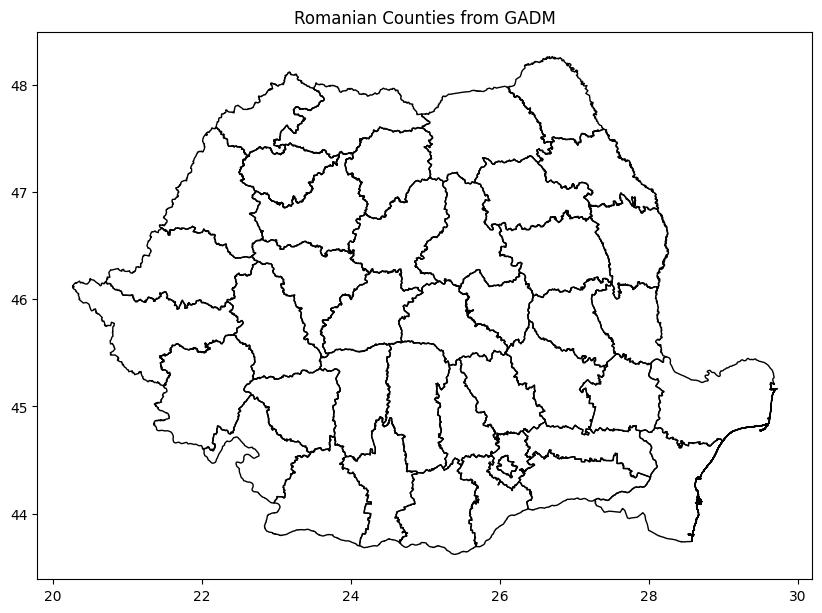

In [ ]:
import matplotlib.pyplot as plt

gdf.plot(figsize=(10, 10), edgecolor='black', facecolor='none')
plt.title("Romanian Counties from GADM")
plt.show()


In [ ]:
import folium
import geopandas as gpd

# Romanian counties shapefile
romania_gdf = gpd.read_file('/content/gadm41_ROU_1/gadm41_ROU_1/gadm41_ROU_1.shp')

# Center the map on Romania
romania_center = [45.9432, 24.9668]
m = folium.Map(location=romania_center, zoom_start=6)

# Add counties to map
folium.GeoJson(romania_gdf.geometry, name="Counties").add_to(m)

# Add Sentinel-2 product footprints
for item in results:
    geo = item.get('GeoFootprint')
    if geo:
        try:
            # Use directly without parsing
            folium.GeoJson(
                geo,
                style_function=lambda x: {
                    'fillColor': 'blue',
                    'color': 'blue',
                    'weight': 1,
                    'fillOpacity': 0.1
                },
                name=f"Product {item['Name']}"
            ).add_to(m)
        except Exception as e:
            print("⚠️ Could not parse footprint:", e)

# Layer control
folium.LayerControl().add_to(m)

# Display the map
m


Output hidden; open in https://colab.research.google.com to view.

- SECTION C: Download Sentinel-2 Imagery for Romania
- SECTION D: Compute NDVI
- SECTION E: U-Net Segmentation
- SECTION F: GIS Masking and % Calculation
- SECTION G: Time Series Comparison
- SECTION H: Visualization and Tables

## We try withouth OAuth token

# Section C: U-Net Segmentation (failed but story)

- Generate labels (vegetation vs non-veg)

- Train small U-Net model

- Predict & visualize segmented outputs

Goal: You want to train a U-Net model for semantic segmentation (e.g., vegetation or NDVI-related classification) on satellite imagery, using your NDVI GeoTIFF files as input.

What You Have:
- NDVI GeoTIFFs per county and year (grayscale raster images, values between 0 and 1)

- Boundaries/masks could be generated or you might have ground truth labels (if supervised learning)

- The data is large and spatially extensive, so patchifying is necessary for training

Key Concepts:
- Patchifying: Splitting large NDVI images into smaller tiles/patches (e.g., 128x128, 256x256 pixels) that fit in memory and GPU.

- Normalization: NDVI values are already normalized (0–1), which is great.

- Labels: If you want to do supervised segmentation (e.g., crop vs non-crop), you need corresponding label masks. Otherwise, unsupervised or self-supervised approaches can be considered.

- Data split: Training, validation, and test sets split spatially or temporally.

- Augmentation: Optional transformations (flips, rotations) to enrich dataset and improve generalization.

**Workflow:**
- Step A: Patchifying NDVI Images
  - Load each GeoTIFF (using rasterio or GDAL)

  - Extract patches of fixed size with some overlap (to avoid edge artifacts)

  - Save patches locally (e.g., as PNG or TIFF) with meaningful names (county_year_x_y.png)

- Step B: Label Preparation (if supervised)
  - Obtain or create masks matching the NDVI patches (same size)

  - Labels could be binary (vegetation/non-vegetation) or multiclass depending on your task

- Step C: Dataset Organization
- Step D: U-Net Model Setup & Training
  - Use a deep learning framework: TensorFlow/Keras or PyTorch

  - Load patches as batches (using tf.data or torch.utils.data.Dataset)

  - Define U-Net architecture (many open-source implementations available)

  - Compile model with appropriate loss (e.g., Dice loss, BCE)

  - Train on patches with validation monitoring

  - Save checkpoints

- Step E: Evaluation and Inference
  - Evaluate on test patches

  - Stitch predicted patches back together for full map predictions

  - Visualize outputs and metrics (IoU, accuracy, etc.)

*What You’ll Need to Know*:
- Basic Python & Deep Learning knowledge: For coding U-Net and training loops

- Raster processing: Reading/writing GeoTIFFs, patch extraction

- Data augmentation: Helps training robustness

- Model tuning: Learning rate, batch size, epochs

- Hardware constraints: Training on Google Colab with GPU limits, so patch size & batch size tuning is important

IMPORTANCE:

- *Validates use of U-Net on satellite-derived vegetation indices.*

- *Helps you learn practical geospatial DL pipeline.*

- *Builds foundation for future projects (crop classification, phenology monitoring, etc.)*

What You Show	|| Why It Matters

NDVI variation across years -	Climate, land-use, or crop pattern changes

Patch generation by county -	Data density comparison and fairness across regions

Thresholded NDVI masks- Simple heuristic to simulate “ground truth” without costly annotation

U-Net performance	- Learn how well a DL model can generalize NDVI-to-binary vegetation detection

Experiment scalability	- Running this pipeline shows full-stack ML: data, processing, modeling, result

Dataset class: ndvi + masks

In [ ]:
import os
from torch.utils.data import Dataset
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

class NDVIDataset(Dataset):
    # Modify the constructor to accept separate paths for images and masks
    def __init__(self, image_dir, mask_dir, transform=None):
        # List .npy files directly in the image_dir and mask_dir
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".npy")])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".npy")])

        # Add a check to ensure image and mask counts match
        if len(self.image_paths) != len(self.mask_paths):
            print(f"Warning: Number of image patches ({len(self.image_paths)}) does not match number of mask patches ({len(self.mask_paths)}). This might cause issues.")

        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx]).astype(np.float32)  # (H, W)
        mask = np.load(self.mask_paths[idx]).astype(np.float32)    # (H, W)

        image = np.expand_dims(image, axis=0)  # Add channel dim: (1, H, W)
        mask = np.expand_dims(mask, axis=0)

        # Ensure image and mask dimensions match if transforms are applied
        if self.transform:
            # It's generally better to apply transformations to image and mask together
            # or ensure they handle numpy arrays/tensors correctly.
            # If using torchvision.transforms, you might need custom logic
            # For simple transforms like ToTensor or normalization, applying separately might be okay
            # provided they don't change spatial dimensions unevenly.
            image = self.transform(torch.from_numpy(image))
            mask = self.transform(torch.from_numpy(mask))
            # Ensure mask stays binary or appropriate format after transform if needed

        return image, mask

In [ ]:
# Instantiate the full dataset
# Corrected: Provide both image_dir and mask_dir paths
full_dataset = NDVIDataset(
    '/content/drive/MyDrive/Romania_by_County/ndvi_patches',
    '/content/drive/MyDrive/Romania_by_County/ndvi_masks' # Add the path to your mask folder
)

# Split into train/val
from torch.utils.data import random_split, DataLoader

val_ratio = 0.2
val_size = int(len(full_dataset) * val_ratio)
train_size = len(full_dataset) - val_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

U-Net model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_c, out_c):  # Conv-BatchNorm-ReLU block
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = nn.Sequential(CBR(1, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.enc3 = nn.Sequential(CBR(128, 256), CBR(256, 256))
        self.enc4 = nn.Sequential(CBR(256, 512), CBR(512, 512))

        self.pool = nn.MaxPool2d(2)

        self.middle = nn.Sequential(CBR(512, 1024), CBR(1024, 1024))

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = nn.Sequential(CBR(1024, 512), CBR(512, 256))

        self.up3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.dec3 = nn.Sequential(CBR(512, 256), CBR(256, 128))

        self.up2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.dec2 = nn.Sequential(CBR(256, 128), CBR(128, 64))

        self.up1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        m = self.middle(self.pool(e4))

        d4 = self.up4(m)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)


Training loop

metric functions

In [ ]:
!pip install tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Metric functions
def dice_score(preds, targets, threshold=0.5, eps=1e-7):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean().item()

def iou_score(preds, targets, threshold=0.5, eps=1e-7):
    preds = (torch.sigmoid(preds) > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = (preds + targets).clamp(0, 1).sum(dim=(1, 2, 3))
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

def accuracy(preds, targets, threshold=0.5):
    preds = (torch.sigmoid(preds) > threshold).float()
    return (preds == targets).float().mean().item()

# Training configuration
num_epochs = 15
history = {'train_loss': [], 'val_loss': [], 'val_dice': [], 'val_iou': [], 'val_accuracy': []}

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = val_dice = val_iou = val_acc = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
            val_dice += dice_score(outputs, masks)
            val_iou += iou_score(outputs, masks)
            val_acc += accuracy(outputs, masks)

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)
    val_acc /= len(val_loader)

    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)
    history['val_accuracy'].append(val_acc)

    print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}\n")


[Epoch 1/15] Training:  55%|█████▍    | 426/776 [2:59:48<2:23:26, 24.59s/it]

Training Curves:
- Loss
- Dice
- IoU
- Accuracy over epochs

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(16, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['val_dice'], label='Val Dice Score')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['val_iou'], label='Val IoU Score')
    plt.title('IoU Score')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['val_accuracy'], label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call it after training
plot_training_history(history)


# Failed

**Download Sentinel-2 Imagery for Romania (2018-2024)**

In [ ]:
import requests

# Example: Top 10 Sentinel-2 products (publicly accessible)
query_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq 'SENTINEL-2'&$top=10"
response = requests.get(query_url)

results = response.json()['value']
for product in results:
    # Use .get() for IngestionDate to handle potential missing keys
    print(product['Name'], product.get('IngestionDate', 'N/A'), product.get('S3Path', 'N/A'))

S2A_OPER_AUX_GNSSRD_POD__20171211T090149_V20150703T064934_20150703T235534 N/A /eodata/Sentinel-2/AUX/AUX_GNSSRD/2015/07/03/S2A_OPER_AUX_GNSSRD_POD__20171211T090149_V20150703T064934_20150703T235534
S2A_OPER_AUX_GNSSRD_POD__20171211T085826_V20150627T070315_20150627T120615 N/A /eodata/Sentinel-2/AUX/AUX_GNSSRD/2015/06/27/S2A_OPER_AUX_GNSSRD_POD__20171211T085826_V20150627T070315_20150627T120615
S2A_OPER_AUX_GNSSRD_POD__20171211T085921_V20150628T023925_20150628T193925 N/A /eodata/Sentinel-2/AUX/AUX_GNSSRD/2015/06/28/S2A_OPER_AUX_GNSSRD_POD__20171211T085921_V20150628T023925_20150628T193925
S2A_OPER_AUX_GNSSRD_POD__20171211T090635_V20150707T235944_20150708T193954 N/A /eodata/Sentinel-2/AUX/AUX_GNSSRD/2015/07/08/S2A_OPER_AUX_GNSSRD_POD__20171211T090635_V20150707T235944_20150708T193954
S2A_OPER_AUX_GNSSRD_POD__20171211T090700_V20150709T135234_20150709T191234 N/A /eodata/Sentinel-2/AUX/AUX_GNSSRD/2015/07/09/S2A_OPER_AUX_GNSSRD_POD__20171211T090700_V20150709T135234_20150709T191234
S2A_OPER_AUX_GN

Step2: Compute NDVI

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Assuming you extracted and loaded B4 (Red) and B8 (NIR)
with rasterio.open('/content/S2_B04.tif') as red:
    red_band = red.read(1).astype('float32')
with rasterio.open('/content/S2_B08.tif') as nir:
    nir_band = nir.read(1).astype('float32')

ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-6)

plt.imshow(ndvi, cmap='YlGn')
plt.colorbar()
plt.title('NDVI')
plt.show()


Step3: segment Vegetation Using U-Net

We want a deep learning model, U-Net, to classify vegetation from NDVI or RGB images.

Here is a minimal PyTorch U-Net that we will try to train on patches:

In [ ]:
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp


full U-Net training and evaluation later — for now, we will first focus on getting clean NDVI maps.

Step 4: Compute Vegetation % by County

Now that we have NDVI maps, we will use a Romania shapefile to aggregate:

In [ ]:
import geopandas as gpd
from rasterstats import zonal_stats

romania = gpd.read_file('/content/drive/MyDrive/romania_counties.shp')

stats = zonal_stats(romania, 'ndvi.tif', stats=['mean'], geojson_out=True)

for county in stats:
    print(county['properties']['NAME_2'], county['properties']['mean'])


Step 5: Visualize and Compare Over Time

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('vegetation_by_county_over_time.csv')
sns.lineplot(data=df, x='year', y='mean_ndvi', hue='county')
